# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [2]:
import datetime
import yaml
import itertools
from pathlib import Path

In [3]:
import jax
import jax.numpy as jnp
from jax.experimental import stax,optimizers

In [4]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned
from zotbin.optimize import *

In [5]:
init_data = load_binned('binned_3_80.npz')

## Framework for Running Studies

In [6]:
def save_study(kw, results, outpath):
    """Save results from a study.
    """
    nbin = kw['nbin']
    init_data = kw['init_data']
    best_scores, dndz_bin, all_scores = results
    np.savez(outpath / f'dndz-{nbin}.npz', dndz=dndz_bin, zedges=init_data[0])
    for scores in all_scores:
        plt.plot(scores, 'r-', alpha=0.3)
    plt.xlabel('Optimization step')
    plt.ylabel(kw.get('metric', 'Score'))
    plt.savefig(outpath / f'training-{nbin}.png')
    plt.show()
    plot_dndz(dndz_bin, init_data[0])
    plt.savefig(outpath / f'dndz-{nbin}.png')
    plt.show()
    with open(outpath / f'scores-{nbin}.yaml', 'w') as f:
        yaml.dump(best_scores, f)

In [7]:
def study_complete(nbin, outpath):
    """Check if a study has already been completed and saved.
    """
    return (outpath / f'scores-{nbin}.yaml').exists()

In [8]:
def run_study(path, func, rerun=[]):
    """Run a study configured by a yaml file.
    """
    path = Path(path)
    with open(path / 'config.yaml') as f:
        config = yaml.safe_load(f)
    nstudy = len(config['nbin'])
    argsiter = []
    argnames = config.keys()
    for arg in argnames:
        if not isinstance(config[arg], list):
            argsiter.append(itertools.repeat(config[arg]))
        elif len(config[arg]) != nstudy:
            print(f'Expected 1 or {nstudy} values for {arg}.')
            return
        else:
            argsiter.append(iter(config[arg]))
    for argvalues in zip(*argsiter):
        kw = dict(zip(argnames, argvalues))
        nbin = kw['nbin']
        outpath = path / f'nbin-{nbin}'
        if not outpath.exists():
            outpath.mkdir()          
        if (not rerun == 'all') and (nbin not in rerun) and study_complete(nbin, outpath):
            # Assume that this job has already run successfully.
            print(f'Skipping already completed job for nbin={nbin}')
            continue
        # Run the optimization for this nbin.
        start = datetime.datetime.now()
        print(f'Starting job at {start} with {kw}')
        results = func(**kw)
        elapsed = datetime.datetime.now() - start
        print(f'Job ran for {elapsed}')
        # Save the results to outpath.
        kw['init_data'] = init_data
        save_study(kw, results, outpath)

## Optimize using redshifts directly

Calculate the normalized dndz for the DC2 and Buzzard datasets using the downsampled binning:

In [9]:
from tomo_challenge import load_redshift

Found classifier Random
You need to install the zotbin package:
  pip install git+https://github.com/dkirkby/zotbin.git
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [10]:
zds = np.asarray(init_data[0])

In [11]:
zdc2 = load_redshift('/media/data2/tomo_challenge_data/ugrizy/training.hdf5')
zbuz = load_redshift('/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5')

In [12]:
dndz_dc2, _ = np.histogram(zdc2, zds)
dndz_dc2 = dndz_dc2 / dndz_dc2.sum()

In [13]:
dndz_buz, _ = np.histogram(zbuz, zds)
dndz_buz = dndz_buz / dndz_buz.sum()

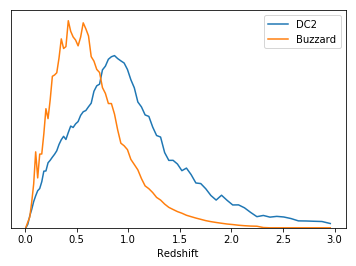

In [14]:
zc = 0.5 * (zds[1:] + zds[:-1])
plt.plot(zc, dndz_dc2, label='DC2')
plt.plot(zc, dndz_buz, label='Buzzard')
plt.xlabel('Redshift')
plt.yticks([])
plt.ylim(0, None)
plt.legend();

In [20]:
def optimize_direct(nbin, ntrial, nsteps, eta, transform, metric, method, seed, sample='buzzard', init_data=init_data):
    dndz_total = dict(buzzard=dndz_buz, dc2=dndz_dc2)[sample]
    mixing = jnp.diag(dndz_total)
    return optimize(
        nbin, mixing, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

Starting job at 2020-09-12 08:28:02.651215 with {'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=955.605 (max=955.605) after 375 steps.
  score=957.159 (max=957.159) after 750 steps.
  score=957.769 (max=957.769) after 1125 steps.
  score=957.982 (max=957.982) after 1500 steps.
trial 1/10: score=957.982 (max=957.982) after 1500 steps.
  score=955.238 (max=957.982) after 375 steps.
  score=956.870 (max=957.982) after 750 steps.
  score=957.457 (max=957.982) after 1125 steps.
  score=957.680 (max=957.982) after 1500 steps.
trial 2/10: score=957.680 (max=957.982) after 1500 steps.
  score=954.029 (max=957.982) after 375 steps.
  score=956.265 (max=957.982) after 750 steps.
  score=956.977 (max=957.982) after 1125 steps.
  score=957.301 (max=957.982) after 1500 steps.
trial 3/10: score=957.301 (max=957.982) after 1500 steps.
  score=954.965 (max=957.982) after 375 steps.
  score=956.954 (max=957.982) af

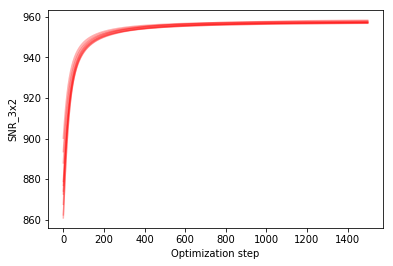

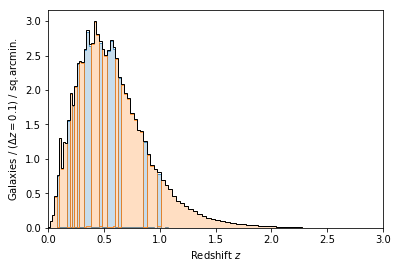

Starting job at 2020-09-12 08:29:09.199452 with {'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1348.412 (max=1348.412) after 750 steps.
  score=1352.992 (max=1352.992) after 1500 steps.
  score=1354.295 (max=1354.295) after 2250 steps.
  score=1354.831 (max=1354.832) after 3000 steps.
trial 1/10: score=1354.831 (max=1354.832) after 3000 steps.
  score=1343.266 (max=1354.832) after 750 steps.
  score=1348.284 (max=1354.832) after 1500 steps.
  score=1349.650 (max=1354.832) after 2250 steps.
  score=1350.258 (max=1354.832) after 3000 steps.
trial 2/10: score=1350.258 (max=1354.832) after 3000 steps.
  score=1345.143 (max=1354.832) after 750 steps.
  score=1349.529 (max=1354.832) after 1500 steps.
  score=1350.761 (max=1354.832) after 2250 steps.
  score=1351.307 (max=1354.832) after 3000 steps.
trial 3/10: score=1351.307 (max=1354.832) after 3000 steps.
  score=1345.419 (max=1354.832) after 750 step

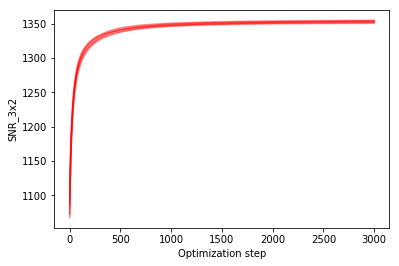

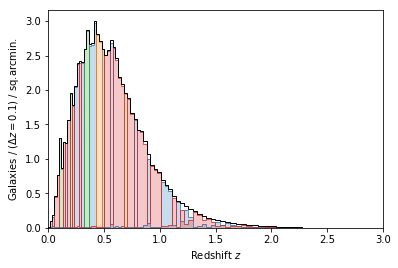

Starting job at 2020-09-12 08:33:08.398162 with {'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1648.356 (max=1648.356) after 1125 steps.
  score=1654.507 (max=1654.507) after 2250 steps.
  score=1656.147 (max=1656.147) after 3375 steps.
  score=1656.783 (max=1656.783) after 4500 steps.
trial 1/10: score=1656.783 (max=1656.783) after 4500 steps.
  score=1644.788 (max=1656.783) after 1125 steps.
  score=1652.141 (max=1656.783) after 2250 steps.
  score=1653.885 (max=1656.783) after 3375 steps.
  score=1654.614 (max=1656.783) after 4500 steps.
trial 2/10: score=1654.614 (max=1656.783) after 4500 steps.
  score=1646.021 (max=1656.783) after 1125 steps.
  score=1652.911 (max=1656.783) after 2250 steps.
  score=1654.466 (max=1656.783) after 3375 steps.
  score=1655.107 (max=1656.783) after 4500 steps.
trial 3/10: score=1655.107 (max=1656.783) after 4500 steps.
  score=1648.591 (max=1656.783) after 1125 

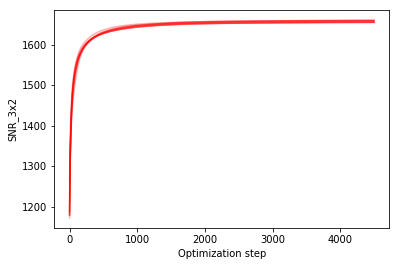

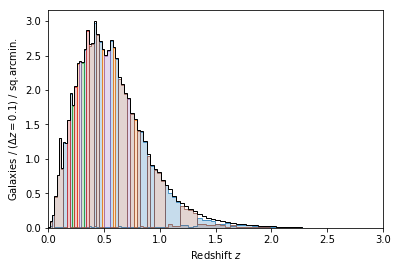

Starting job at 2020-09-12 08:46:06.861944 with {'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1901.414 (max=1901.414) after 1500 steps.
  score=1909.754 (max=1909.754) after 3000 steps.
  score=1911.429 (max=1911.429) after 4500 steps.
  score=1912.072 (max=1912.072) after 6000 steps.
trial 1/10: score=1912.072 (max=1912.072) after 6000 steps.
  score=1903.137 (max=1912.072) after 1500 steps.
  score=1911.545 (max=1912.072) after 3000 steps.
  score=1913.328 (max=1913.328) after 4500 steps.
  score=1914.045 (max=1914.045) after 6000 steps.
trial 2/10: score=1914.045 (max=1914.045) after 6000 steps.
  score=1901.476 (max=1914.045) after 1500 steps.
  score=1909.745 (max=1914.045) after 3000 steps.
  score=1912.036 (max=1914.045) after 4500 steps.
  score=1913.039 (max=1914.045) after 6000 steps.
trial 3/10: score=1913.039 (max=1914.045) after 6000 steps.
  score=1904.130 (max=1914.045) after 1500 

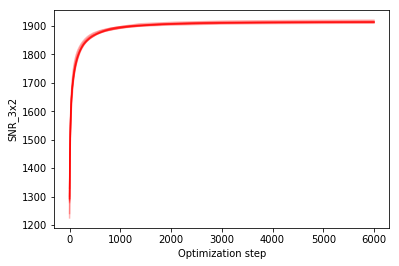

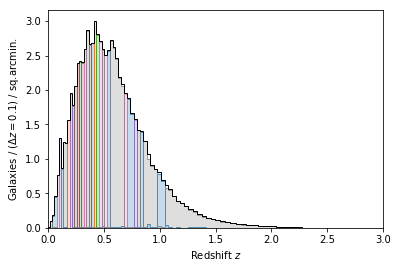

Starting job at 2020-09-12 09:07:57.128845 with {'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=2128.023 (max=2128.023) after 1875 steps.
  score=2136.240 (max=2136.240) after 3750 steps.
  score=2137.820 (max=2137.820) after 5625 steps.
  score=2138.340 (max=2138.340) after 7500 steps.
trial 1/10: score=2138.340 (max=2138.340) after 7500 steps.
  score=2132.479 (max=2138.340) after 1875 steps.
  score=2139.691 (max=2139.694) after 3750 steps.
  score=2141.437 (max=2141.439) after 5625 steps.
  score=2142.070 (max=2142.070) after 7500 steps.
trial 2/10: score=2142.070 (max=2142.070) after 7500 steps.
  score=2127.079 (max=2142.070) after 1875 steps.
  score=2134.944 (max=2142.070) after 3750 steps.
  score=2138.330 (max=2142.070) after 5625 steps.
  score=2138.993 (max=2142.070) after 7500 steps.
trial 3/10: score=2138.993 (max=2142.070) after 7500 steps.
  score=2136.525 (max=2142.070) after 1875

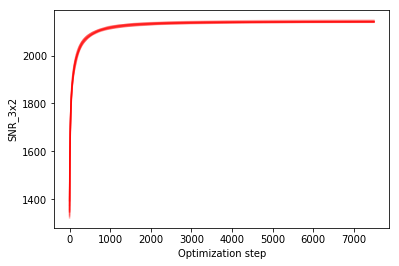

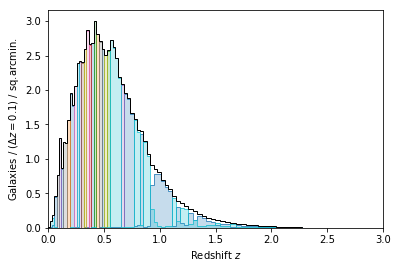

In [16]:
run_study('results/direct-snr', optimize_direct, rerun='all')

Starting job at 2020-09-12 09:56:03.640886 with {'nbin': 2, 'ntrial': 30, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=1014.991 (max=1014.991) after 375 steps.
  score=1041.739 (max=1041.819) after 750 steps.
  score=1046.351 (max=1046.371) after 1125 steps.
  score=1047.727 (max=1047.807) after 1500 steps.
trial 1/30: score=1047.727 (max=1047.807) after 1500 steps.
  score=819.192 (max=1047.807) after 375 steps.
  score=845.817 (max=1047.807) after 750 steps.
  score=849.981 (max=1047.807) after 1125 steps.
  score=851.347 (max=1047.807) after 1500 steps.
trial 2/30: score=851.347 (max=1047.807) after 1500 steps.
  score=1184.443 (max=1184.443) after 375 steps.
  score=1337.382 (max=1337.382) after 750 steps.
  score=1347.984 (max=1348.071) after 1125 steps.
  score=1370.075 (max=1370.180) after 1500 steps.
trial 3/30: score=1370.075 (max=1370.180) after 1500 steps.
  score=1002.951 (max=1370.180) after 375 steps.
  sco

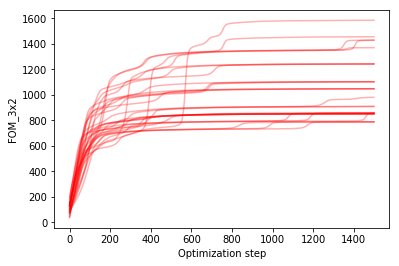

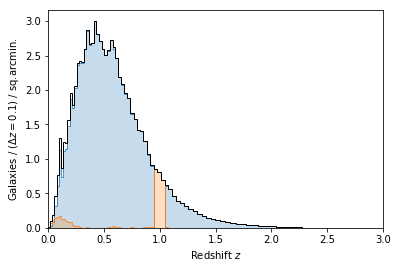

Starting job at 2020-09-12 09:59:34.194087 with {'nbin': 4, 'ntrial': 30, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=3293.794 (max=3293.794) after 750 steps.
  score=3415.151 (max=3415.432) after 1500 steps.
  score=3423.888 (max=3424.106) after 2250 steps.
  score=3449.183 (max=3449.628) after 3000 steps.
trial 1/30: score=3449.183 (max=3449.628) after 3000 steps.
  score=3312.602 (max=3449.628) after 750 steps.
  score=3440.443 (max=3449.628) after 1500 steps.
  score=3452.871 (max=3454.208) after 2250 steps.
  score=3462.626 (max=3463.749) after 3000 steps.
trial 2/30: score=3462.626 (max=3463.749) after 3000 steps.
  score=3201.791 (max=3463.749) after 750 steps.
  score=3276.058 (max=3463.749) after 1500 steps.
  score=3291.986 (max=3463.749) after 2250 steps.
  score=3300.429 (max=3463.749) after 3000 steps.
trial 3/30: score=3300.429 (max=3463.749) after 3000 steps.
  score=3026.687 (max=3463.749) after 750 step

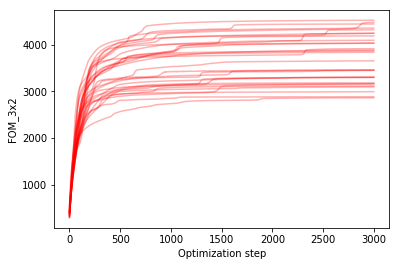

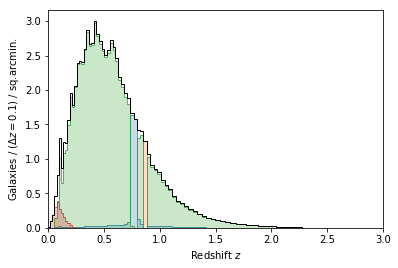

Starting job at 2020-09-12 10:11:58.330815 with {'nbin': 6, 'ntrial': 30, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=5999.993 (max=6000.306) after 1125 steps.
  score=6088.442 (max=6090.560) after 2250 steps.
  score=6113.410 (max=6114.341) after 3375 steps.
  score=6128.883 (max=6129.301) after 4500 steps.
trial 1/30: score=6128.883 (max=6129.301) after 4500 steps.
  score=6101.405 (max=6129.301) after 1125 steps.
  score=6149.653 (max=6150.133) after 2250 steps.
  score=6170.111 (max=6172.941) after 3375 steps.
  score=6188.899 (max=6189.452) after 4500 steps.
trial 2/30: score=6188.899 (max=6189.452) after 4500 steps.
  score=5688.012 (max=6189.452) after 1125 steps.
  score=5724.270 (max=6189.452) after 2250 steps.
  score=5739.762 (max=6189.452) after 3375 steps.
  score=5751.389 (max=6189.452) after 4500 steps.
trial 3/30: score=5751.389 (max=6189.452) after 4500 steps.
  score=5635.782 (max=6189.452) after 1125 

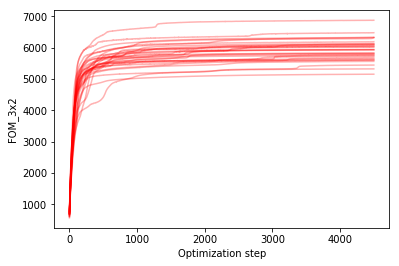

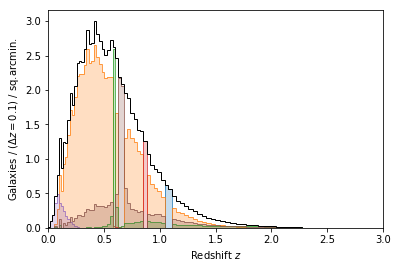

Starting job at 2020-09-12 10:52:15.855148 with {'nbin': 8, 'ntrial': 30, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=8227.594 (max=8228.285) after 1500 steps.
  score=8316.068 (max=8316.068) after 3000 steps.
  score=8346.301 (max=8351.516) after 4500 steps.
  score=8364.564 (max=8368.410) after 6000 steps.
trial 1/30: score=8364.564 (max=8368.410) after 6000 steps.
  score=7048.588 (max=8368.410) after 1500 steps.
  score=7135.457 (max=8368.410) after 3000 steps.
  score=7169.780 (max=8368.410) after 4500 steps.
  score=7211.027 (max=8368.410) after 6000 steps.
trial 2/30: score=7211.027 (max=8368.410) after 6000 steps.
  score=7204.897 (max=8368.410) after 1500 steps.
  score=7393.022 (max=8368.410) after 3000 steps.
  score=7438.958 (max=8368.410) after 4500 steps.
  score=7516.944 (max=8368.410) after 6000 steps.
trial 3/30: score=7516.944 (max=8368.410) after 6000 steps.
  score=7052.859 (max=8368.410) after 1500 

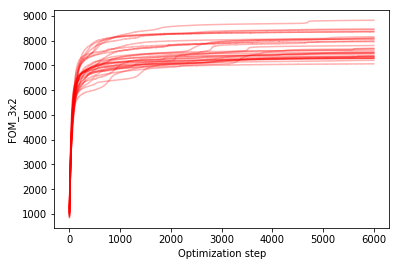

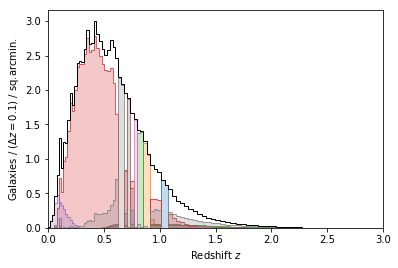

Starting job at 2020-09-12 12:01:46.732730 with {'nbin': 10, 'ntrial': 30, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=8993.471 (max=8995.477) after 1875 steps.
  score=9333.424 (max=9336.240) after 3750 steps.
  score=9463.569 (max=9467.747) after 5625 steps.
  score=9534.315 (max=9538.057) after 7500 steps.
trial 1/30: score=9534.315 (max=9538.057) after 7500 steps.
  score=8598.890 (max=9538.057) after 1875 steps.
  score=8769.336 (max=9538.057) after 3750 steps.
  score=9007.225 (max=9538.057) after 5625 steps.
  score=9112.062 (max=9538.057) after 7500 steps.
trial 2/30: score=9112.062 (max=9538.057) after 7500 steps.
  score=8120.572 (max=9538.057) after 1875 steps.
  score=8317.436 (max=9538.057) after 3750 steps.
  score=8350.528 (max=9538.057) after 5625 steps.
  score=8453.451 (max=9538.057) after 7500 steps.
trial 3/30: score=8453.451 (max=9538.057) after 7500 steps.
  score=9469.854 (max=9538.057) after 1875

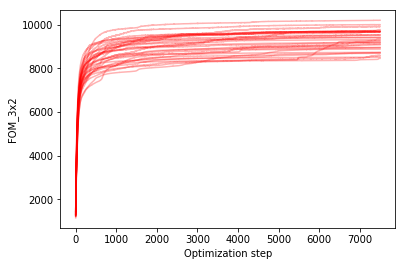

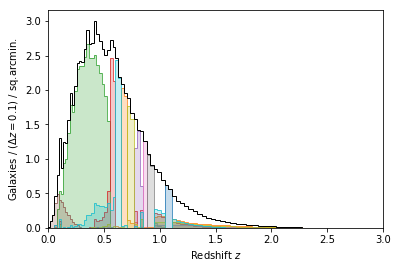

In [17]:
run_study('results/direct-fom', optimize_direct, rerun='all')

Starting job at 2020-09-12 14:33:51.033476 with {'nbin': 2, 'ntrial': 10, 'nsteps': 1000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=21.005 (max=21.005) after 250 steps.
  score=22.130 (max=22.130) after 500 steps.
  score=22.428 (max=22.428) after 750 steps.
  score=22.540 (max=22.541) after 1000 steps.
trial 1/10: score=22.540 (max=22.541) after 1000 steps.
  score=20.315 (max=22.541) after 250 steps.
  score=21.743 (max=22.541) after 500 steps.
  score=22.249 (max=22.541) after 750 steps.
  score=22.442 (max=22.541) after 1000 steps.
trial 2/10: score=22.442 (max=22.541) after 1000 steps.
  score=20.267 (max=22.541) after 250 steps.
  score=21.703 (max=22.541) after 500 steps.
  score=22.237 (max=22.541) after 750 steps.
  score=22.437 (max=22.541) after 1000 steps.
trial 3/10: score=22.437 (max=22.541) after 1000 steps.
  score=20.525 (max=22.541) after 250 steps.
  score=21.840 (max=22.541) after 500 steps.
  score=22.271 (m

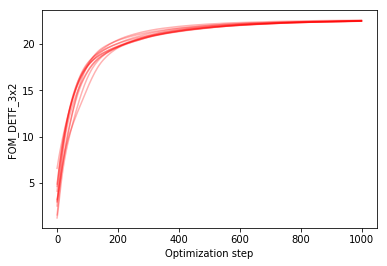

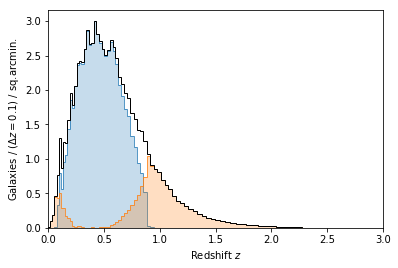

Starting job at 2020-09-12 14:34:50.451894 with {'nbin': 4, 'ntrial': 10, 'nsteps': 2000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=63.138 (max=63.138) after 500 steps.
  score=65.545 (max=65.545) after 1000 steps.
  score=66.204 (max=66.206) after 1500 steps.
  score=66.477 (max=66.477) after 2000 steps.
trial 1/10: score=66.477 (max=66.477) after 2000 steps.
  score=62.032 (max=66.477) after 500 steps.
  score=65.575 (max=66.477) after 1000 steps.
  score=66.204 (max=66.477) after 1500 steps.
  score=66.674 (max=66.676) after 2000 steps.
trial 2/10: score=66.674 (max=66.676) after 2000 steps.
  score=61.979 (max=66.676) after 500 steps.
  score=65.160 (max=66.676) after 1000 steps.
  score=65.860 (max=66.676) after 1500 steps.
  score=66.344 (max=66.676) after 2000 steps.
trial 3/10: score=66.344 (max=66.676) after 2000 steps.
  score=64.164 (max=66.676) after 500 steps.
  score=65.613 (max=66.676) after 1000 steps.
  score=66

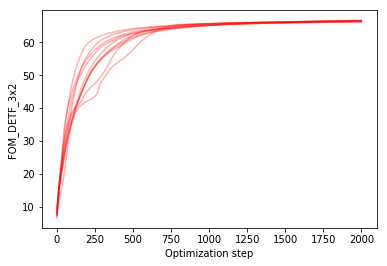

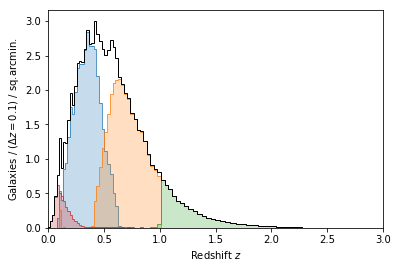

Starting job at 2020-09-12 14:37:49.166857 with {'nbin': 6, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=80.013 (max=80.058) after 750 steps.
  score=82.462 (max=82.462) after 1500 steps.
  score=84.355 (max=84.363) after 2250 steps.
  score=85.285 (max=85.320) after 3000 steps.
trial 1/10: score=85.285 (max=85.320) after 3000 steps.
  score=81.419 (max=85.320) after 750 steps.
  score=84.239 (max=85.320) after 1500 steps.
  score=85.343 (max=85.369) after 2250 steps.
  score=85.890 (max=85.912) after 3000 steps.
trial 2/10: score=85.890 (max=85.912) after 3000 steps.
  score=81.035 (max=85.912) after 750 steps.
  score=84.491 (max=85.912) after 1500 steps.
  score=85.583 (max=85.912) after 2250 steps.
  score=86.102 (max=86.124) after 3000 steps.
trial 3/10: score=86.102 (max=86.124) after 3000 steps.
  score=78.877 (max=86.124) after 750 steps.
  score=85.332 (max=86.124) after 1500 steps.
  score=86

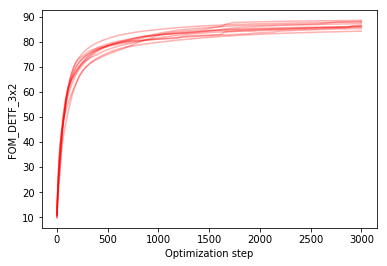

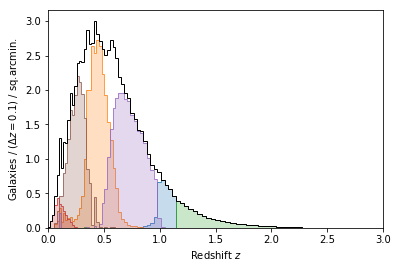

Starting job at 2020-09-12 14:47:03.508621 with {'nbin': 8, 'ntrial': 10, 'nsteps': 4000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=98.644 (max=98.652) after 1000 steps.
  score=102.766 (max=102.810) after 2000 steps.
  score=104.857 (max=104.882) after 3000 steps.
  score=105.795 (max=105.848) after 4000 steps.
trial 1/10: score=105.795 (max=105.848) after 4000 steps.
  score=99.341 (max=105.848) after 1000 steps.
  score=102.699 (max=105.848) after 2000 steps.
  score=104.178 (max=105.848) after 3000 steps.
  score=104.993 (max=105.848) after 4000 steps.
trial 2/10: score=104.993 (max=105.848) after 4000 steps.
  score=94.572 (max=105.848) after 1000 steps.
  score=98.805 (max=105.848) after 2000 steps.
  score=101.357 (max=105.848) after 3000 steps.
  score=102.859 (max=105.848) after 4000 steps.
trial 3/10: score=102.859 (max=105.848) after 4000 steps.
  score=94.649 (max=105.848) after 1000 steps.
  score=98.909 (max=105.84

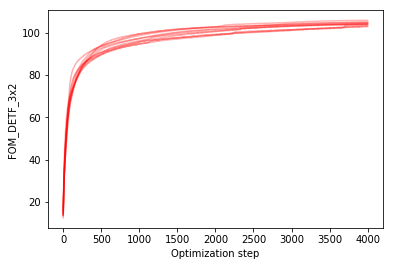

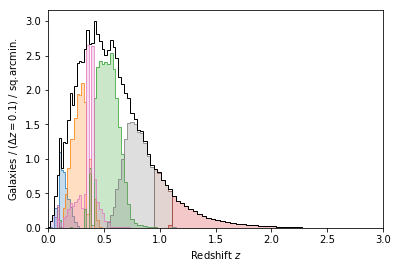

Starting job at 2020-09-12 15:02:52.127282 with {'nbin': 10, 'ntrial': 10, 'nsteps': 5000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=115.982 (max=115.991) after 1250 steps.
  score=119.270 (max=119.322) after 2500 steps.
  score=121.191 (max=121.191) after 3750 steps.
  score=121.960 (max=121.960) after 5000 steps.
trial 1/10: score=121.960 (max=121.960) after 5000 steps.
  score=112.065 (max=121.960) after 1250 steps.
  score=116.816 (max=121.960) after 2500 steps.
  score=118.513 (max=121.960) after 3750 steps.
  score=119.814 (max=121.960) after 5000 steps.
trial 2/10: score=119.814 (max=121.960) after 5000 steps.
  score=114.599 (max=121.960) after 1250 steps.
  score=118.217 (max=121.960) after 2500 steps.
  score=120.307 (max=121.960) after 3750 steps.
  score=121.373 (max=121.960) after 5000 steps.
trial 3/10: score=121.373 (max=121.960) after 5000 steps.
  score=112.105 (max=121.960) after 1250 steps.
  score=115.696 (ma

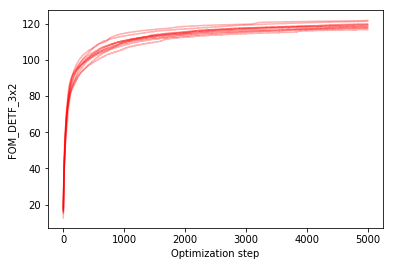

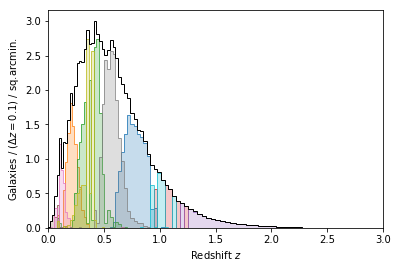

In [18]:
run_study('results/direct-detf', optimize_direct, rerun='all')

Starting job at 2020-09-12 17:25:13.426931 with {'sample': 'dc2', 'nbin': 2, 'ntrial': 10, 'nsteps': 1000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=38.614 (max=38.614) after 250 steps.
  score=39.841 (max=39.841) after 500 steps.
  score=40.171 (max=40.171) after 750 steps.
  score=40.309 (max=40.310) after 1000 steps.
trial 1/10: score=40.309 (max=40.310) after 1000 steps.
  score=38.568 (max=40.310) after 250 steps.
  score=39.824 (max=40.310) after 500 steps.
  score=40.165 (max=40.310) after 750 steps.
  score=40.307 (max=40.310) after 1000 steps.
trial 2/10: score=40.307 (max=40.310) after 1000 steps.
  score=38.269 (max=40.310) after 250 steps.
  score=39.711 (max=40.310) after 500 steps.
  score=40.100 (max=40.310) after 750 steps.
  score=40.268 (max=40.310) after 1000 steps.
trial 3/10: score=40.268 (max=40.310) after 1000 steps.
  score=38.693 (max=40.310) after 250 steps.
  score=39.872 (max=40.310) after 500 steps.


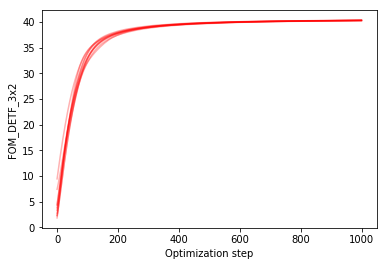

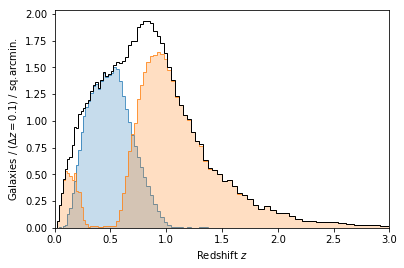

Starting job at 2020-09-12 17:26:12.413819 with {'sample': 'dc2', 'nbin': 4, 'ntrial': 10, 'nsteps': 2000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=108.653 (max=108.653) after 500 steps.
  score=114.168 (max=114.168) after 1000 steps.
  score=116.071 (max=116.081) after 1500 steps.
  score=116.987 (max=116.993) after 2000 steps.
trial 1/10: score=116.987 (max=116.993) after 2000 steps.
  score=114.339 (max=116.993) after 500 steps.
  score=117.404 (max=117.407) after 1000 steps.
  score=118.262 (max=118.276) after 1500 steps.
  score=118.583 (max=118.589) after 2000 steps.
trial 2/10: score=118.583 (max=118.589) after 2000 steps.
  score=106.499 (max=118.589) after 500 steps.
  score=113.594 (max=118.589) after 1000 steps.
  score=115.906 (max=118.589) after 1500 steps.
  score=116.959 (max=118.589) after 2000 steps.
trial 3/10: score=116.959 (max=118.589) after 2000 steps.
  score=109.998 (max=118.589) after 500 steps.
  score

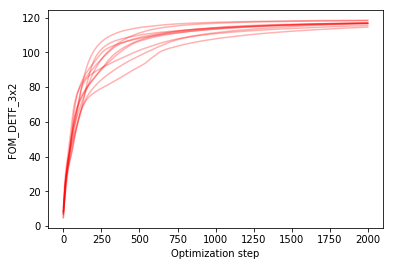

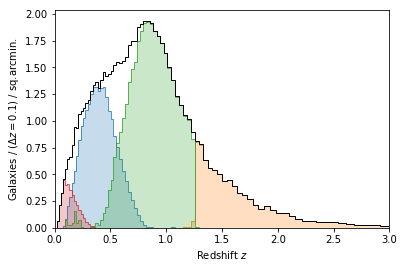

Starting job at 2020-09-12 17:29:11.490678 with {'sample': 'dc2', 'nbin': 6, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=135.269 (max=135.273) after 750 steps.
  score=141.606 (max=141.642) after 1500 steps.
  score=143.632 (max=143.632) after 2250 steps.
  score=144.681 (max=144.689) after 3000 steps.
trial 1/10: score=144.681 (max=144.689) after 3000 steps.
  score=139.003 (max=144.689) after 750 steps.
  score=144.086 (max=144.689) after 1500 steps.
  score=146.175 (max=146.176) after 2250 steps.
  score=147.158 (max=147.181) after 3000 steps.
trial 2/10: score=147.158 (max=147.181) after 3000 steps.
  score=134.750 (max=147.181) after 750 steps.
  score=142.745 (max=147.181) after 1500 steps.
  score=145.188 (max=147.181) after 2250 steps.
  score=146.487 (max=147.181) after 3000 steps.
trial 3/10: score=146.487 (max=147.181) after 3000 steps.
  score=132.459 (max=147.181) after 750 steps.
  score

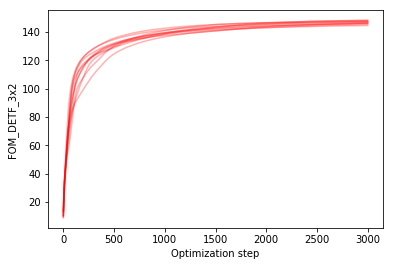

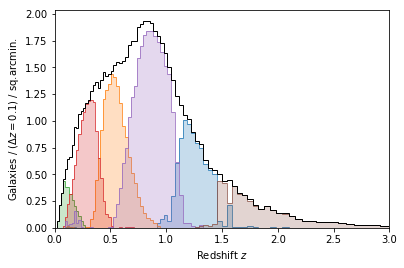

Starting job at 2020-09-12 17:38:31.772294 with {'sample': 'dc2', 'nbin': 8, 'ntrial': 10, 'nsteps': 4000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=155.887 (max=155.887) after 1000 steps.
  score=163.292 (max=163.307) after 2000 steps.
  score=165.360 (max=165.386) after 3000 steps.
  score=167.616 (max=167.642) after 4000 steps.
trial 1/10: score=167.616 (max=167.642) after 4000 steps.
  score=154.611 (max=167.642) after 1000 steps.
  score=163.250 (max=167.642) after 2000 steps.
  score=166.067 (max=167.642) after 3000 steps.
  score=167.634 (max=167.674) after 4000 steps.
trial 2/10: score=167.634 (max=167.674) after 4000 steps.
  score=158.737 (max=167.674) after 1000 steps.
  score=164.790 (max=167.674) after 2000 steps.
  score=167.144 (max=167.674) after 3000 steps.
  score=168.692 (max=168.715) after 4000 steps.
trial 3/10: score=168.692 (max=168.715) after 4000 steps.
  score=158.165 (max=168.715) after 1000 steps.
  s

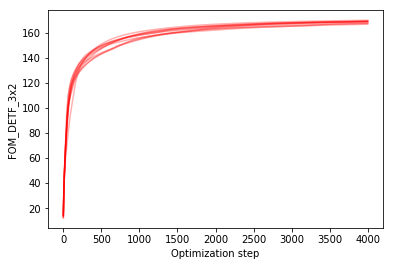

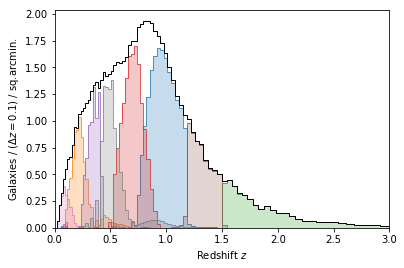

Starting job at 2020-09-12 17:54:29.691104 with {'sample': 'dc2', 'nbin': 10, 'ntrial': 10, 'nsteps': 5000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=175.210 (max=175.210) after 1250 steps.
  score=181.716 (max=181.716) after 2500 steps.
  score=184.583 (max=184.644) after 3750 steps.
  score=187.171 (max=187.233) after 5000 steps.
trial 1/10: score=187.171 (max=187.233) after 5000 steps.
  score=174.514 (max=187.233) after 1250 steps.
  score=182.605 (max=187.233) after 2500 steps.
  score=185.883 (max=187.233) after 3750 steps.
  score=187.415 (max=187.446) after 5000 steps.
trial 2/10: score=187.415 (max=187.446) after 5000 steps.
  score=173.404 (max=187.446) after 1250 steps.
  score=185.579 (max=187.446) after 2500 steps.
  score=188.876 (max=188.916) after 3750 steps.
  score=190.120 (max=190.176) after 5000 steps.
trial 3/10: score=190.120 (max=190.176) after 5000 steps.
  score=175.077 (max=190.176) after 1250 steps.
  

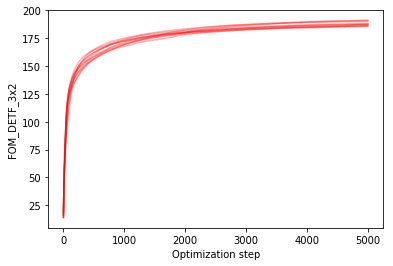

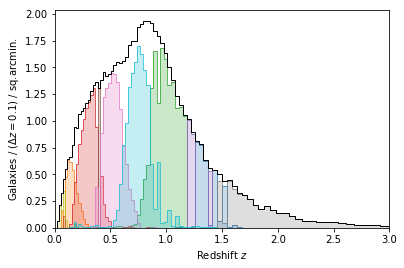

In [21]:
run_study('results/direct-detf-dc2', optimize_direct)

In [ ]:
run_study('results/direct-snr-dc2', optimize_direct)

In [ ]:
run_study('results/direct-fom-dc2', optimize_direct)

## Optimize redshift bins using features

In [23]:
def optimize_bins(nbin, groups, ntrial, nsteps, eta, transform, metric, method, seed, init_data=init_data):
    _, _, _, zhist, _ = load_groups(groups + '.npz')
    ngrp, nzin = zhist.shape
    nzout = len(init_data[0]) - 1
    assert nzin % nzout == 0
    downsampling = nzin // nzout
    if downsampling > 1:
        print(f'Downsampling by {downsampling}.')
        zhist = zhist.reshape(ngrp, nzout, downsampling).sum(axis=-1)
    mixing = jnp.array(zhist / zhist.sum())
    return optimize(
        nbin, mixing, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

Running job with {'groups': 'group_emd_80_300', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.752 (max=18.752) after 375 steps.
  score=19.682 (max=19.682) after 750 steps.
  score=20.034 (max=20.035) after 1125 steps.
  score=20.168 (max=20.169) after 1500 steps.
trial 1/10: score=20.168 (max=20.169) after 1500 steps.
  score=18.649 (max=20.169) after 375 steps.
  score=19.624 (max=20.169) after 750 steps.
  score=20.020 (max=20.169) after 1125 steps.
  score=20.167 (max=20.169) after 1500 steps.
trial 2/10: score=20.167 (max=20.169) after 1500 steps.
  score=18.570 (max=20.169) after 375 steps.
  score=19.670 (max=20.169) after 750 steps.
  score=20.039 (max=20.169) after 1125 steps.
  score=20.166 (max=20.169) after 1500 steps.
trial 3/10: score=20.166 (max=20.169) after 1500 steps.
  score=18.571 (max=20.169) after 375 steps.
  score=19.585 (max=20.169) after 750 steps.
  score=19.943 

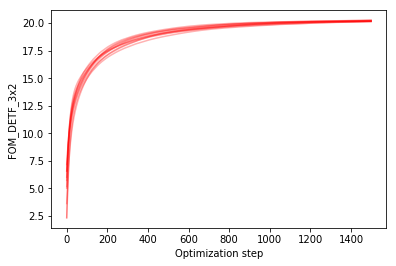

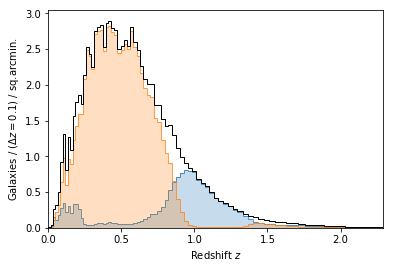

Running job with {'groups': 'group_emd_80_300', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=52.925 (max=52.925) after 750 steps.
  score=54.055 (max=54.057) after 1500 steps.
  score=54.387 (max=54.392) after 2250 steps.
  score=54.553 (max=54.554) after 3000 steps.
trial 1/10: score=54.553 (max=54.554) after 3000 steps.
  score=52.212 (max=54.554) after 750 steps.
  score=54.348 (max=54.554) after 1500 steps.
  score=54.758 (max=54.759) after 2250 steps.
  score=54.866 (max=54.866) after 3000 steps.
trial 2/10: score=54.866 (max=54.866) after 3000 steps.
  score=50.931 (max=54.866) after 750 steps.
  score=53.400 (max=54.866) after 1500 steps.
  score=54.073 (max=54.866) after 2250 steps.
  score=54.403 (max=54.866) after 3000 steps.
trial 3/10: score=54.403 (max=54.866) after 3000 steps.
  score=50.820 (max=54.866) after 750 steps.
  score=53.177 (max=54.866) after 1500 steps.
  score=54.

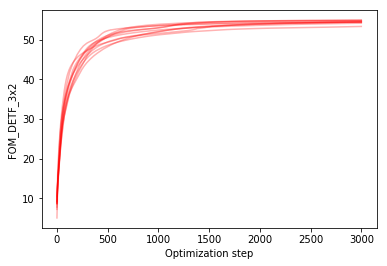

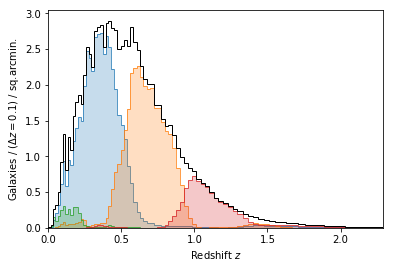

Running job with {'groups': 'group_emd_80_300', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=63.730 (max=63.750) after 1125 steps.
  score=66.081 (max=66.102) after 2250 steps.
  score=67.348 (max=67.348) after 3375 steps.
  score=68.057 (max=68.063) after 4500 steps.
trial 1/10: score=68.057 (max=68.063) after 4500 steps.
  score=64.464 (max=68.063) after 1125 steps.
  score=65.891 (max=68.063) after 2250 steps.
  score=66.519 (max=68.063) after 3375 steps.
  score=66.958 (max=68.063) after 4500 steps.
trial 2/10: score=66.958 (max=68.063) after 4500 steps.
  score=64.454 (max=68.063) after 1125 steps.
  score=66.114 (max=68.063) after 2250 steps.
  score=66.896 (max=68.063) after 3375 steps.
  score=67.387 (max=68.063) after 4500 steps.
trial 3/10: score=67.387 (max=68.063) after 4500 steps.
  score=64.627 (max=68.063) after 1125 steps.
  score=66.486 (max=68.063) after 2250 steps.
  score

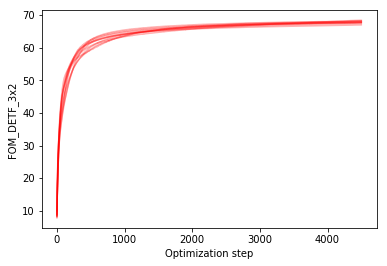

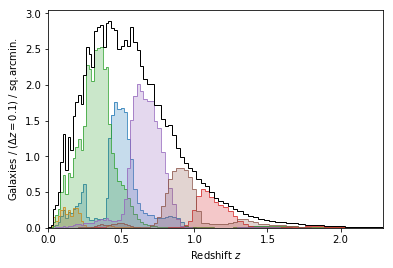

Running job with {'groups': 'group_emd_80_300', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.710 (max=71.710) after 1500 steps.
  score=74.673 (max=74.677) after 3000 steps.
  score=76.120 (max=76.138) after 4500 steps.
  score=76.729 (max=76.729) after 6000 steps.
trial 1/10: score=76.729 (max=76.729) after 6000 steps.
  score=74.573 (max=76.729) after 1500 steps.
  score=77.402 (max=77.409) after 3000 steps.
  score=78.391 (max=78.394) after 4500 steps.
  score=78.841 (max=78.843) after 6000 steps.
trial 2/10: score=78.841 (max=78.843) after 6000 steps.
  score=75.480 (max=78.843) after 1500 steps.
  score=77.484 (max=78.843) after 3000 steps.
  score=78.221 (max=78.843) after 4500 steps.
  score=78.680 (max=78.843) after 6000 steps.
trial 3/10: score=78.680 (max=78.843) after 6000 steps.
  score=73.366 (max=78.843) after 1500 steps.
  score=75.275 (max=78.843) after 3000 steps.
  score

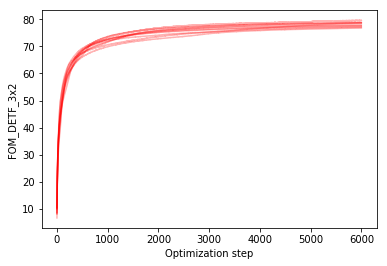

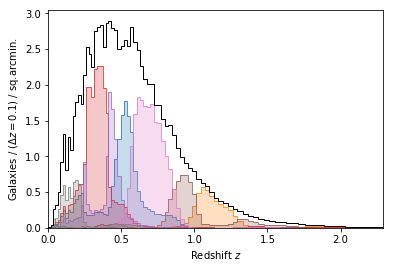

Running job with {'groups': 'group_emd_80_300', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.101 (max=81.120) after 1875 steps.
  score=85.266 (max=85.266) after 3750 steps.
  score=86.467 (max=86.471) after 5625 steps.
  score=87.029 (max=87.038) after 7500 steps.
trial 1/10: score=87.029 (max=87.038) after 7500 steps.
  score=81.465 (max=87.038) after 1875 steps.
  score=84.560 (max=87.038) after 3750 steps.
  score=86.085 (max=87.038) after 5625 steps.
  score=86.781 (max=87.038) after 7500 steps.
trial 2/10: score=86.781 (max=87.038) after 7500 steps.
  score=81.607 (max=87.038) after 1875 steps.
  score=84.219 (max=87.038) after 3750 steps.
  score=85.604 (max=87.038) after 5625 steps.
  score=86.362 (max=87.038) after 7500 steps.
trial 3/10: score=86.362 (max=87.038) after 7500 steps.
  score=79.166 (max=87.038) after 1875 steps.
  score=82.730 (max=87.038) after 3750 steps.
  scor

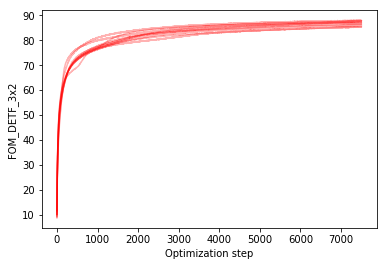

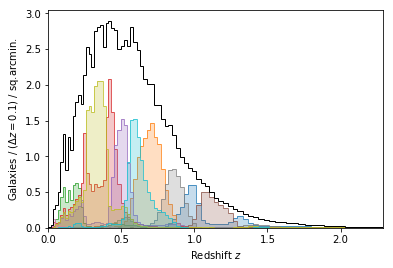

In [38]:
run_study('results/edm-300-detf', optimize_bins)

Running job with {'groups': 'group_emd_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.912 (max=18.912) after 375 steps.
  score=19.846 (max=19.846) after 750 steps.
  score=20.112 (max=20.112) after 1125 steps.
  score=20.240 (max=20.241) after 1500 steps.
trial 1/10: score=20.240 (max=20.241) after 1500 steps.
  score=18.660 (max=20.241) after 375 steps.
  score=19.697 (max=20.241) after 750 steps.
  score=20.038 (max=20.241) after 1125 steps.
  score=20.170 (max=20.241) after 1500 steps.
trial 2/10: score=20.170 (max=20.241) after 1500 steps.
  score=18.688 (max=20.241) after 375 steps.
  score=19.695 (max=20.241) after 750 steps.
  score=20.051 (max=20.241) after 1125 steps.
  score=20.170 (max=20.241) after 1500 steps.
trial 3/10: score=20.170 (max=20.241) after 1500 steps.
  score=18.411 (max=20.241) after 375 steps.
  score=19.536 (max=20.241) after 750 steps.
  score=19.980 

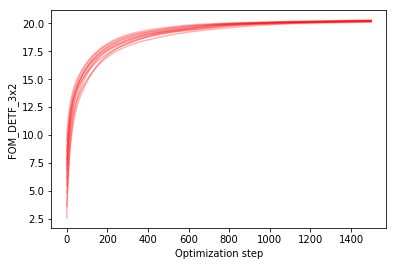

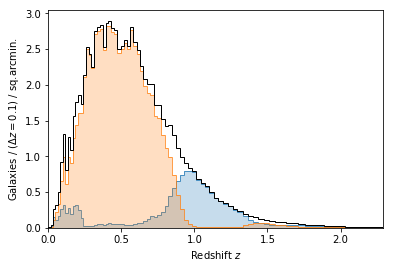

Running job with {'groups': 'group_emd_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=49.656 (max=49.657) after 750 steps.
  score=51.712 (max=51.712) after 1500 steps.
  score=52.510 (max=52.513) after 2250 steps.
  score=53.238 (max=53.240) after 3000 steps.
trial 1/10: score=53.238 (max=53.240) after 3000 steps.
  score=52.426 (max=53.240) after 750 steps.
  score=53.688 (max=53.696) after 1500 steps.
  score=54.145 (max=54.147) after 2250 steps.
  score=54.365 (max=54.367) after 3000 steps.
trial 2/10: score=54.365 (max=54.367) after 3000 steps.
  score=49.246 (max=54.367) after 750 steps.
  score=51.540 (max=54.367) after 1500 steps.
  score=52.777 (max=54.367) after 2250 steps.
  score=54.332 (max=54.367) after 3000 steps.
trial 3/10: score=54.332 (max=54.367) after 3000 steps.
  score=51.126 (max=54.367) after 750 steps.
  score=53.829 (max=54.367) after 1500 steps.
  score=54.

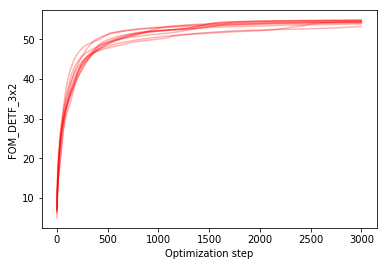

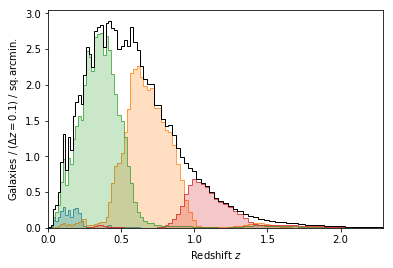

Running job with {'groups': 'group_emd_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=65.338 (max=65.345) after 1125 steps.
  score=66.816 (max=66.816) after 2250 steps.
  score=67.453 (max=67.453) after 3375 steps.
  score=67.781 (max=67.798) after 4500 steps.
trial 1/10: score=67.781 (max=67.798) after 4500 steps.
  score=65.428 (max=67.798) after 1125 steps.
  score=66.856 (max=67.798) after 2250 steps.
  score=67.475 (max=67.798) after 3375 steps.
  score=67.871 (max=67.877) after 4500 steps.
trial 2/10: score=67.871 (max=67.877) after 4500 steps.
  score=65.787 (max=67.877) after 1125 steps.
  score=67.421 (max=67.877) after 2250 steps.
  score=67.858 (max=67.882) after 3375 steps.
  score=68.245 (max=68.257) after 4500 steps.
trial 3/10: score=68.245 (max=68.257) after 4500 steps.
  score=64.001 (max=68.257) after 1125 steps.
  score=66.737 (max=68.257) after 2250 steps.
  score

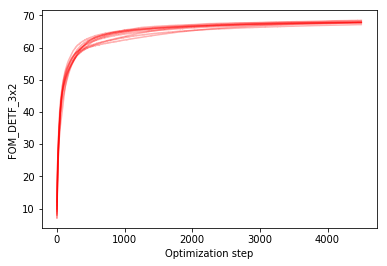

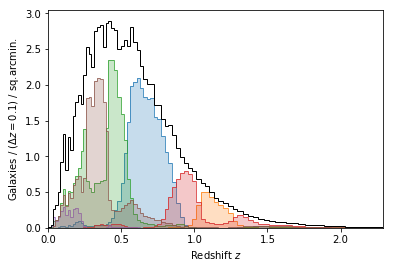

Running job with {'groups': 'group_emd_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.000 (max=71.053) after 1500 steps.
  score=73.854 (max=73.865) after 3000 steps.
  score=75.633 (max=75.649) after 4500 steps.
  score=76.310 (max=76.352) after 6000 steps.
trial 1/10: score=76.310 (max=76.352) after 6000 steps.
  score=75.798 (max=76.352) after 1500 steps.
  score=77.366 (max=77.458) after 3000 steps.
  score=77.988 (max=78.132) after 4500 steps.
  score=78.784 (max=78.993) after 6000 steps.
trial 2/10: score=78.784 (max=78.993) after 6000 steps.
  score=73.588 (max=78.993) after 1500 steps.
  score=76.105 (max=78.993) after 3000 steps.
  score=76.865 (max=78.993) after 4500 steps.
  score=77.243 (max=78.993) after 6000 steps.
trial 3/10: score=77.243 (max=78.993) after 6000 steps.
  score=75.180 (max=78.993) after 1500 steps.
  score=77.113 (max=78.993) after 3000 steps.
  score

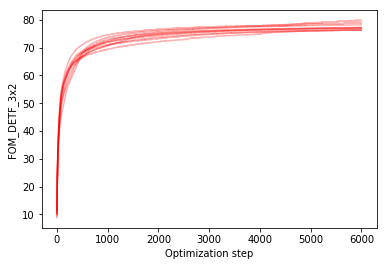

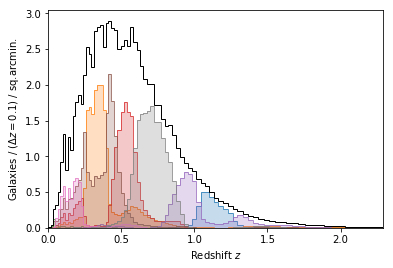

Running job with {'groups': 'group_emd_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=80.462 (max=80.642) after 1875 steps.
  score=83.813 (max=84.048) after 3750 steps.
  score=85.579 (max=85.579) after 5625 steps.
  score=86.167 (max=86.279) after 7500 steps.
trial 1/10: score=86.167 (max=86.279) after 7500 steps.
  score=81.119 (max=86.279) after 1875 steps.
  score=83.277 (max=86.279) after 3750 steps.
  score=84.266 (max=86.279) after 5625 steps.
  score=84.842 (max=86.279) after 7500 steps.
trial 2/10: score=84.842 (max=86.279) after 7500 steps.
  score=79.266 (max=86.279) after 1875 steps.
  score=80.829 (max=86.279) after 3750 steps.
  score=82.854 (max=86.279) after 5625 steps.
  score=85.485 (max=86.279) after 7500 steps.
trial 3/10: score=85.485 (max=86.279) after 7500 steps.
  score=83.282 (max=86.279) after 1875 steps.
  score=85.747 (max=86.279) after 3750 steps.
  scor

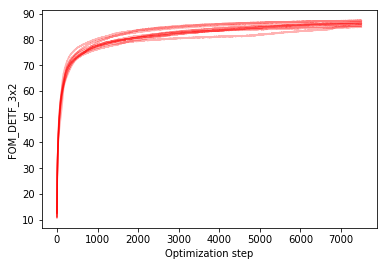

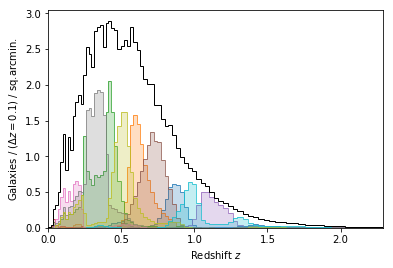

In [39]:
run_study('results/edm-150-detf', optimize_bins)

Starting job at 2020-09-12 18:29:20.287427 with {'groups': 'group_cos_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.467 (max=18.467) after 375 steps.
  score=19.697 (max=19.697) after 750 steps.
  score=20.108 (max=20.108) after 1125 steps.
  score=20.274 (max=20.275) after 1500 steps.
trial 1/10: score=20.274 (max=20.275) after 1500 steps.
  score=18.712 (max=20.275) after 375 steps.
  score=19.784 (max=20.275) after 750 steps.
  score=20.162 (max=20.275) after 1125 steps.
  score=20.315 (max=20.315) after 1500 steps.
trial 2/10: score=20.315 (max=20.315) after 1500 steps.
  score=19.150 (max=20.315) after 375 steps.
  score=20.010 (max=20.315) after 750 steps.
  score=20.271 (max=20.315) after 1125 steps.
  score=20.362 (max=20.363) after 1500 steps.
trial 3/10: score=20.362 (max=20.363) after 1500 steps.
  score=18.519 (max=20.363) after 375 steps.
  score=19.686 (max=20.363) a

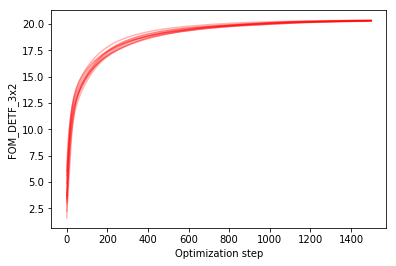

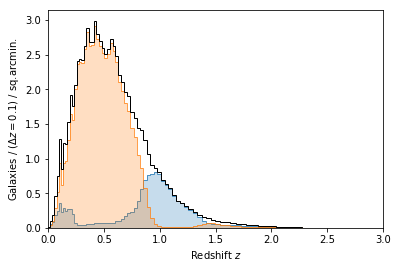

Starting job at 2020-09-12 18:30:36.788856 with {'groups': 'group_cos_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=50.171 (max=50.171) after 750 steps.
  score=54.484 (max=54.487) after 1500 steps.
  score=54.957 (max=54.967) after 2250 steps.
  score=55.147 (max=55.162) after 3000 steps.
trial 1/10: score=55.147 (max=55.162) after 3000 steps.
  score=49.100 (max=55.162) after 750 steps.
  score=51.159 (max=55.162) after 1500 steps.
  score=54.596 (max=55.162) after 2250 steps.
  score=55.001 (max=55.162) after 3000 steps.
trial 2/10: score=55.001 (max=55.162) after 3000 steps.
  score=53.509 (max=55.162) after 750 steps.
  score=55.163 (max=55.163) after 1500 steps.
  score=55.377 (max=55.381) after 2250 steps.
  score=55.565 (max=55.567) after 3000 steps.
trial 3/10: score=55.565 (max=55.567) after 3000 steps.
  score=52.733 (max=55.567) after 750 steps.
  score=54.400 (max=55.567

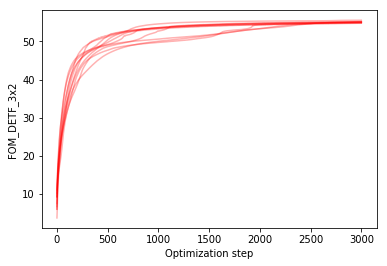

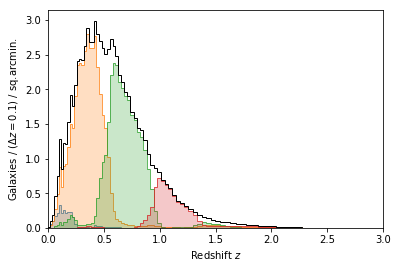

Starting job at 2020-09-12 18:34:53.893972 with {'groups': 'group_cos_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=64.883 (max=64.887) after 1125 steps.
  score=67.672 (max=67.683) after 2250 steps.
  score=68.663 (max=68.663) after 3375 steps.
  score=69.111 (max=69.131) after 4500 steps.
trial 1/10: score=69.111 (max=69.131) after 4500 steps.
  score=65.531 (max=69.131) after 1125 steps.
  score=67.998 (max=69.131) after 2250 steps.
  score=69.063 (max=69.131) after 3375 steps.
  score=69.612 (max=69.615) after 4500 steps.
trial 2/10: score=69.612 (max=69.615) after 4500 steps.
  score=66.405 (max=69.615) after 1125 steps.
  score=68.941 (max=69.615) after 2250 steps.
  score=69.549 (max=69.615) after 3375 steps.
  score=69.868 (max=69.882) after 4500 steps.
trial 3/10: score=69.868 (max=69.882) after 4500 steps.
  score=64.626 (max=69.882) after 1125 steps.
  score=67.187 (max=69

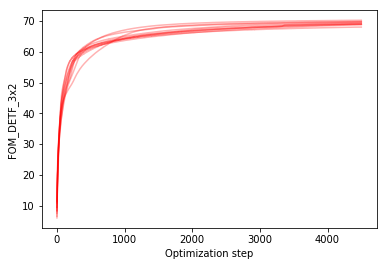

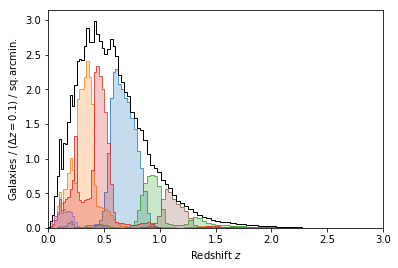

Starting job at 2020-09-12 18:48:39.123475 with {'groups': 'group_cos_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=75.835 (max=75.865) after 1500 steps.
  score=77.544 (max=77.560) after 3000 steps.
  score=78.262 (max=78.270) after 4500 steps.
  score=78.656 (max=78.666) after 6000 steps.
trial 1/10: score=78.656 (max=78.666) after 6000 steps.
  score=73.551 (max=78.666) after 1500 steps.
  score=76.075 (max=78.666) after 3000 steps.
  score=77.320 (max=78.666) after 4500 steps.
  score=78.190 (max=78.666) after 6000 steps.
trial 2/10: score=78.190 (max=78.666) after 6000 steps.
  score=76.521 (max=78.666) after 1500 steps.
  score=78.607 (max=78.666) after 3000 steps.
  score=79.423 (max=79.433) after 4500 steps.
  score=79.868 (max=79.880) after 6000 steps.
trial 3/10: score=79.868 (max=79.880) after 6000 steps.
  score=73.178 (max=79.880) after 1500 steps.
  score=76.338 (max=79

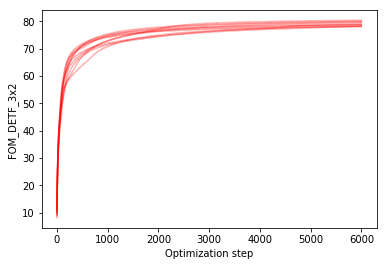

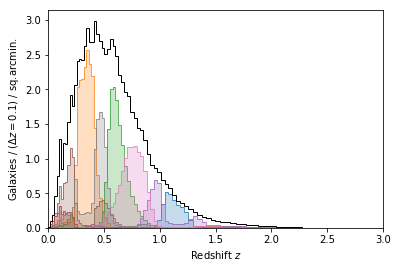

Starting job at 2020-09-12 19:12:12.209502 with {'groups': 'group_cos_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=84.577 (max=84.584) after 1875 steps.
  score=87.477 (max=87.502) after 3750 steps.
  score=88.475 (max=88.495) after 5625 steps.
  score=88.978 (max=88.989) after 7500 steps.
trial 1/10: score=88.978 (max=88.989) after 7500 steps.
  score=83.634 (max=88.989) after 1875 steps.
  score=87.478 (max=88.989) after 3750 steps.
  score=88.668 (max=88.989) after 5625 steps.
  score=89.210 (max=89.221) after 7500 steps.
trial 2/10: score=89.210 (max=89.221) after 7500 steps.
  score=84.338 (max=89.221) after 1875 steps.
  score=86.865 (max=89.221) after 3750 steps.
  score=88.189 (max=89.221) after 5625 steps.
  score=88.696 (max=89.221) after 7500 steps.
trial 3/10: score=88.696 (max=89.221) after 7500 steps.
  score=84.549 (max=89.221) after 1875 steps.
  score=87.471 (max=8

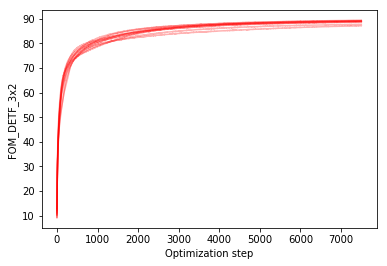

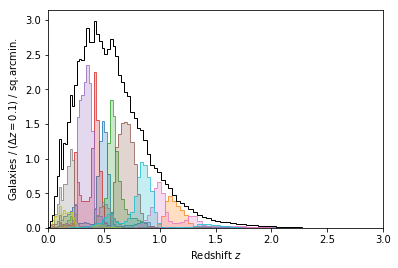

In [24]:
run_study('results/cos-150-detf', optimize_bins, rerun='all')

Starting job at 2020-09-12 20:42:15.759917 with {'groups': 'group_cos_15pct_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.876 (max=18.876) after 375 steps.
  score=19.852 (max=19.852) after 750 steps.
  score=20.178 (max=20.179) after 1125 steps.
  score=20.288 (max=20.288) after 1500 steps.
trial 1/10: score=20.288 (max=20.288) after 1500 steps.
  score=19.056 (max=20.288) after 375 steps.
  score=19.900 (max=20.288) after 750 steps.
  score=20.197 (max=20.288) after 1125 steps.
  score=20.298 (max=20.299) after 1500 steps.
trial 2/10: score=20.298 (max=20.299) after 1500 steps.
  score=18.679 (max=20.299) after 375 steps.
  score=19.723 (max=20.299) after 750 steps.
  score=20.106 (max=20.299) after 1125 steps.
  score=20.224 (max=20.299) after 1500 steps.
trial 3/10: score=20.224 (max=20.299) after 1500 steps.
  score=18.836 (max=20.299) after 375 steps.
  score=19.811 (max=20.299

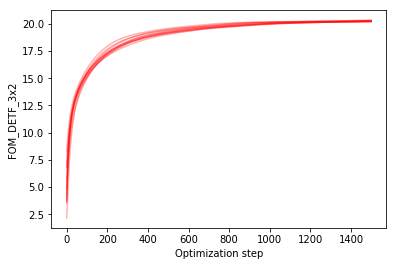

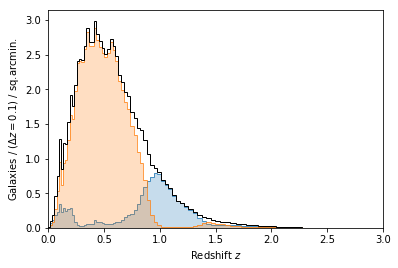

Starting job at 2020-09-12 20:43:27.313163 with {'groups': 'group_cos_15pct_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=52.198 (max=52.198) after 750 steps.
  score=54.469 (max=54.472) after 1500 steps.
  score=54.839 (max=54.842) after 2250 steps.
  score=55.052 (max=55.053) after 3000 steps.
trial 1/10: score=55.052 (max=55.053) after 3000 steps.
  score=51.944 (max=55.053) after 750 steps.
  score=54.303 (max=55.053) after 1500 steps.
  score=54.806 (max=55.053) after 2250 steps.
  score=54.992 (max=55.053) after 3000 steps.
trial 2/10: score=54.992 (max=55.053) after 3000 steps.
  score=51.951 (max=55.053) after 750 steps.
  score=54.826 (max=55.053) after 1500 steps.
  score=55.173 (max=55.174) after 2250 steps.
  score=55.289 (max=55.291) after 3000 steps.
trial 3/10: score=55.289 (max=55.291) after 3000 steps.
  score=52.806 (max=55.291) after 750 steps.
  score=53.943 (max=55.

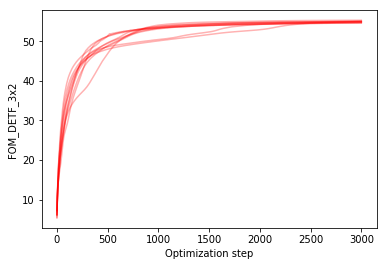

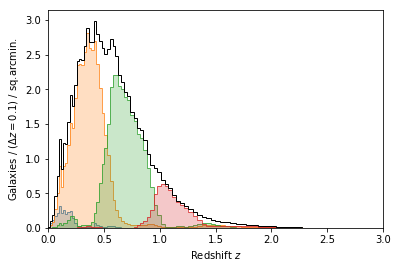

Starting job at 2020-09-12 20:47:37.104426 with {'groups': 'group_cos_15pct_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=64.790 (max=64.790) after 1125 steps.
  score=66.557 (max=66.557) after 2250 steps.
  score=67.428 (max=67.428) after 3375 steps.
  score=67.957 (max=67.964) after 4500 steps.
trial 1/10: score=67.957 (max=67.964) after 4500 steps.
  score=66.182 (max=67.964) after 1125 steps.
  score=68.001 (max=68.022) after 2250 steps.
  score=68.711 (max=68.712) after 3375 steps.
  score=69.029 (max=69.029) after 4500 steps.
trial 2/10: score=69.029 (max=69.029) after 4500 steps.
  score=65.861 (max=69.029) after 1125 steps.
  score=67.455 (max=69.029) after 2250 steps.
  score=68.069 (max=69.029) after 3375 steps.
  score=68.449 (max=69.029) after 4500 steps.
trial 3/10: score=68.449 (max=69.029) after 4500 steps.
  score=62.866 (max=69.029) after 1125 steps.
  score=65.733 (max

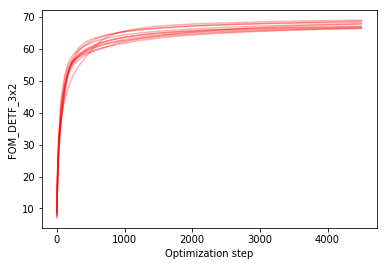

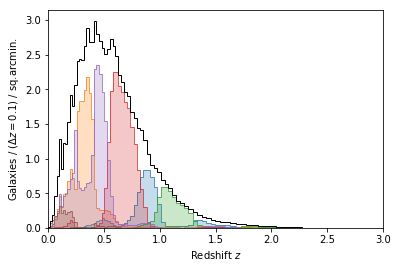

Starting job at 2020-09-12 21:01:21.382763 with {'groups': 'group_cos_15pct_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=75.279 (max=75.279) after 1500 steps.
  score=77.772 (max=77.786) after 3000 steps.
  score=78.701 (max=78.710) after 4500 steps.
  score=79.130 (max=79.144) after 6000 steps.
trial 1/10: score=79.130 (max=79.144) after 6000 steps.
  score=73.561 (max=79.144) after 1500 steps.
  score=75.459 (max=79.144) after 3000 steps.
  score=76.222 (max=79.144) after 4500 steps.
  score=76.640 (max=79.144) after 6000 steps.
trial 2/10: score=76.640 (max=79.144) after 6000 steps.
  score=74.006 (max=79.144) after 1500 steps.
  score=77.370 (max=79.144) after 3000 steps.
  score=78.464 (max=79.144) after 4500 steps.
  score=78.962 (max=79.144) after 6000 steps.
trial 3/10: score=78.962 (max=79.144) after 6000 steps.
  score=76.379 (max=79.144) after 1500 steps.
  score=78.351 (max

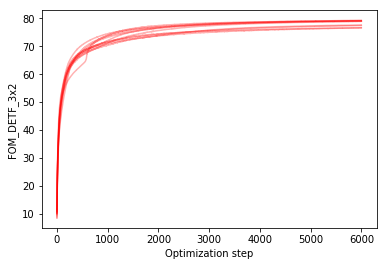

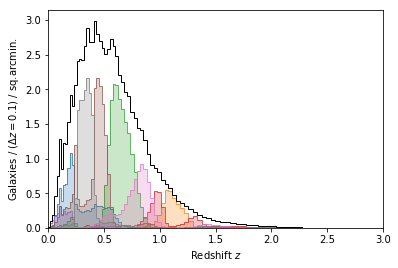

Starting job at 2020-09-12 21:25:16.313741 with {'groups': 'group_cos_15pct_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.827 (max=81.843) after 1875 steps.
  score=85.498 (max=85.514) after 3750 steps.
  score=86.642 (max=86.677) after 5625 steps.
  score=87.139 (max=87.169) after 7500 steps.
trial 1/10: score=87.139 (max=87.169) after 7500 steps.
  score=82.144 (max=87.169) after 1875 steps.
  score=84.990 (max=87.169) after 3750 steps.
  score=86.132 (max=87.169) after 5625 steps.
  score=86.766 (max=87.169) after 7500 steps.
trial 2/10: score=86.766 (max=87.169) after 7500 steps.
  score=82.470 (max=87.169) after 1875 steps.
  score=86.450 (max=87.169) after 3750 steps.
  score=87.493 (max=87.501) after 5625 steps.
  score=87.787 (max=87.806) after 7500 steps.
trial 3/10: score=87.787 (max=87.806) after 7500 steps.
  score=81.353 (max=87.806) after 1875 steps.
  score=84.271 (ma

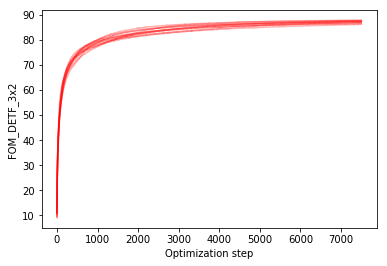

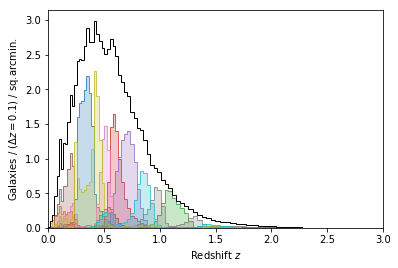

In [26]:
run_study('results/cos-15pct-150-detf', optimize_bins)

Running job with {'groups': 'group_wgt_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.402 (max=18.402) after 375 steps.
  score=19.546 (max=19.546) after 750 steps.
  score=19.872 (max=19.874) after 1125 steps.
  score=20.003 (max=20.003) after 1500 steps.
trial 1/10: score=20.003 (max=20.003) after 1500 steps.
  score=18.531 (max=20.003) after 375 steps.
  score=19.533 (max=20.003) after 750 steps.
  score=19.868 (max=20.003) after 1125 steps.
  score=20.011 (max=20.012) after 1500 steps.
trial 2/10: score=20.011 (max=20.012) after 1500 steps.
  score=18.505 (max=20.012) after 375 steps.
  score=19.521 (max=20.012) after 750 steps.
  score=19.878 (max=20.012) after 1125 steps.
  score=20.002 (max=20.012) after 1500 steps.
trial 3/10: score=20.002 (max=20.012) after 1500 steps.
  score=19.064 (max=20.012) after 375 steps.
  score=19.803 (max=20.012) after 750 steps.
  score=20.013 

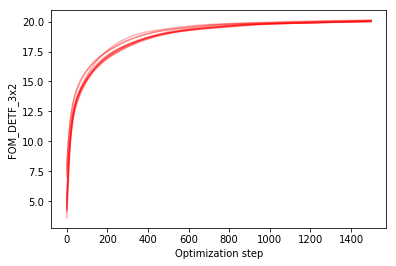

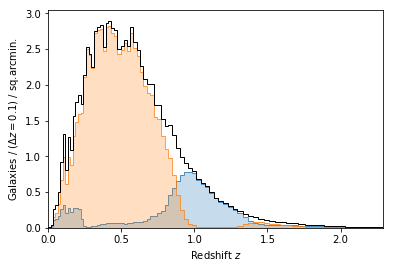

Running job with {'groups': 'group_wgt_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=48.263 (max=48.263) after 750 steps.
  score=49.613 (max=49.613) after 1500 steps.
  score=50.279 (max=50.286) after 2250 steps.
  score=50.870 (max=50.870) after 3000 steps.
trial 1/10: score=50.870 (max=50.870) after 3000 steps.
  score=52.572 (max=52.584) after 750 steps.
  score=53.276 (max=53.294) after 1500 steps.
  score=53.569 (max=53.571) after 2250 steps.
  score=53.723 (max=53.738) after 3000 steps.
trial 2/10: score=53.723 (max=53.738) after 3000 steps.
  score=49.665 (max=53.738) after 750 steps.
  score=53.589 (max=53.738) after 1500 steps.
  score=54.008 (max=54.009) after 2250 steps.
  score=54.114 (max=54.116) after 3000 steps.
trial 3/10: score=54.114 (max=54.116) after 3000 steps.
  score=51.828 (max=54.116) after 750 steps.
  score=53.835 (max=54.116) after 1500 steps.
  score=54.

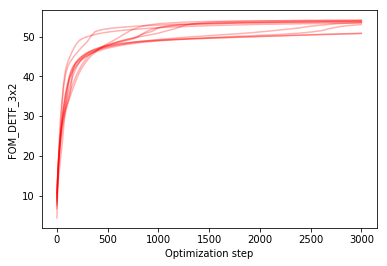

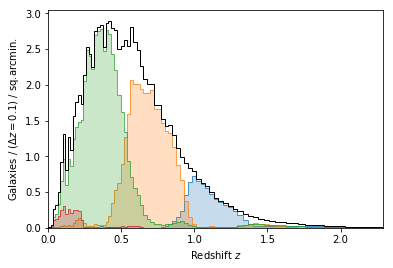

Running job with {'groups': 'group_wgt_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=65.049 (max=65.049) after 1125 steps.
  score=66.773 (max=66.786) after 2250 steps.
  score=67.351 (max=67.356) after 3375 steps.
  score=67.618 (max=67.634) after 4500 steps.
trial 1/10: score=67.618 (max=67.634) after 4500 steps.
  score=64.364 (max=67.634) after 1125 steps.
  score=66.429 (max=67.634) after 2250 steps.
  score=67.114 (max=67.634) after 3375 steps.
  score=67.431 (max=67.634) after 4500 steps.
trial 2/10: score=67.431 (max=67.634) after 4500 steps.
  score=61.874 (max=67.634) after 1125 steps.
  score=64.269 (max=67.634) after 2250 steps.
  score=65.736 (max=67.634) after 3375 steps.
  score=66.597 (max=67.634) after 4500 steps.
trial 3/10: score=66.597 (max=67.634) after 4500 steps.
  score=64.591 (max=67.634) after 1125 steps.
  score=66.221 (max=67.634) after 2250 steps.
  score

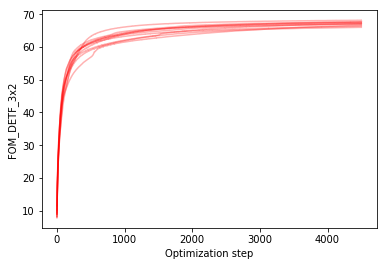

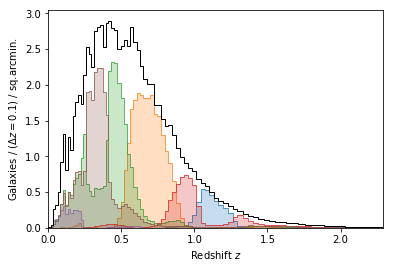

Running job with {'groups': 'group_wgt_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.722 (max=71.722) after 1500 steps.
  score=73.336 (max=73.344) after 3000 steps.
  score=74.072 (max=74.111) after 4500 steps.
  score=74.589 (max=74.589) after 6000 steps.
trial 1/10: score=74.589 (max=74.589) after 6000 steps.
  score=73.902 (max=74.589) after 1500 steps.
  score=76.348 (max=76.368) after 3000 steps.
  score=77.171 (max=77.194) after 4500 steps.
  score=77.599 (max=77.613) after 6000 steps.
trial 2/10: score=77.599 (max=77.613) after 6000 steps.
  score=72.856 (max=77.613) after 1500 steps.
  score=74.885 (max=77.613) after 3000 steps.
  score=75.585 (max=77.613) after 4500 steps.
  score=76.051 (max=77.613) after 6000 steps.
trial 3/10: score=76.051 (max=77.613) after 6000 steps.
  score=72.313 (max=77.613) after 1500 steps.
  score=73.915 (max=77.613) after 3000 steps.
  score

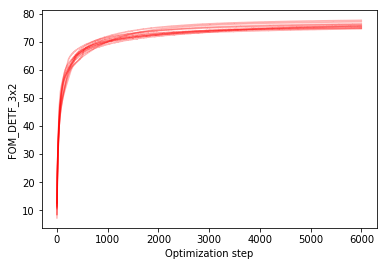

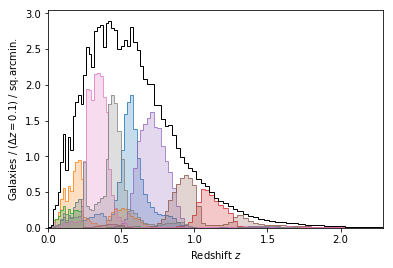

Running job with {'groups': 'group_wgt_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.996 (max=82.047) after 1875 steps.
  score=84.960 (max=85.005) after 3750 steps.
  score=85.917 (max=85.922) after 5625 steps.
  score=86.372 (max=86.394) after 7500 steps.
trial 1/10: score=86.372 (max=86.394) after 7500 steps.
  score=80.694 (max=86.394) after 1875 steps.
  score=83.228 (max=86.394) after 3750 steps.
  score=84.197 (max=86.394) after 5625 steps.
  score=85.024 (max=86.394) after 7500 steps.
trial 2/10: score=85.024 (max=86.394) after 7500 steps.
  score=82.485 (max=86.394) after 1875 steps.
  score=85.197 (max=86.394) after 3750 steps.
  score=86.047 (max=86.394) after 5625 steps.
  score=86.446 (max=86.464) after 7500 steps.
trial 3/10: score=86.446 (max=86.464) after 7500 steps.
  score=78.802 (max=86.464) after 1875 steps.
  score=82.465 (max=86.464) after 3750 steps.
  scor

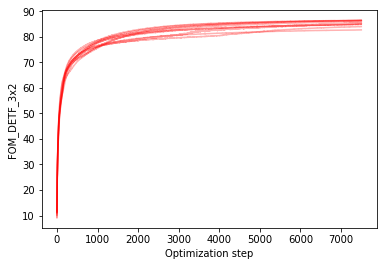

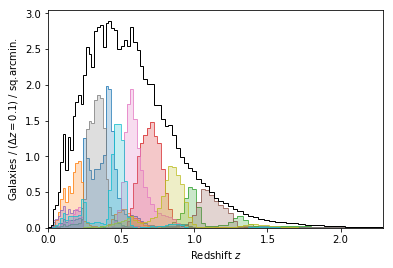

In [41]:
run_study('results/wgt-150-detf', optimize_bins)

Running job with {'groups': 'group_cos_80_75', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.837 (max=18.837) after 375 steps.
  score=19.904 (max=19.904) after 750 steps.
  score=20.125 (max=20.126) after 1125 steps.
  score=20.206 (max=20.206) after 1500 steps.
trial 1/10: score=20.206 (max=20.206) after 1500 steps.
  score=18.540 (max=20.206) after 375 steps.
  score=19.696 (max=20.206) after 750 steps.
  score=20.059 (max=20.206) after 1125 steps.
  score=20.158 (max=20.206) after 1500 steps.
trial 2/10: score=20.158 (max=20.206) after 1500 steps.
  score=18.595 (max=20.206) after 375 steps.
  score=19.793 (max=20.206) after 750 steps.
  score=20.082 (max=20.206) after 1125 steps.
  score=20.170 (max=20.206) after 1500 steps.
trial 3/10: score=20.170 (max=20.206) after 1500 steps.
  score=19.154 (max=20.206) after 375 steps.
  score=20.005 (max=20.206) after 750 steps.
  score=20.154 (

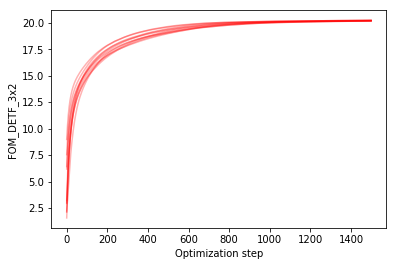

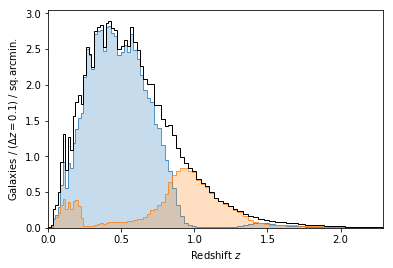

Running job with {'groups': 'group_cos_80_75', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=51.999 (max=52.002) after 750 steps.
  score=53.417 (max=53.421) after 1500 steps.
  score=53.825 (max=53.831) after 2250 steps.
  score=53.999 (max=54.004) after 3000 steps.
trial 1/10: score=53.999 (max=54.004) after 3000 steps.
  score=49.796 (max=54.004) after 750 steps.
  score=52.933 (max=54.004) after 1500 steps.
  score=53.709 (max=54.004) after 2250 steps.
  score=53.950 (max=54.004) after 3000 steps.
trial 2/10: score=53.950 (max=54.004) after 3000 steps.
  score=52.369 (max=54.004) after 750 steps.
  score=53.338 (max=54.004) after 1500 steps.
  score=53.696 (max=54.004) after 2250 steps.
  score=53.875 (max=54.004) after 3000 steps.
trial 3/10: score=53.875 (max=54.004) after 3000 steps.
  score=51.628 (max=54.004) after 750 steps.
  score=53.171 (max=54.004) after 1500 steps.
  score=53.6

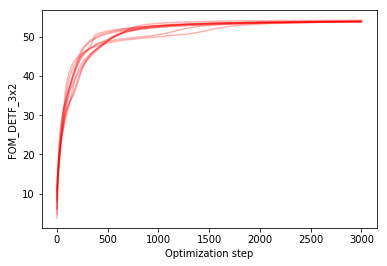

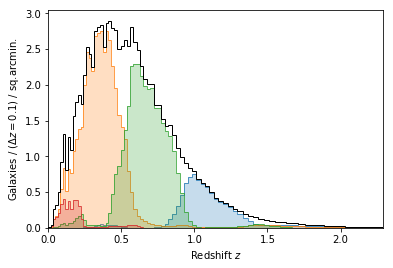

Running job with {'groups': 'group_cos_80_75', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=60.567 (max=60.567) after 1125 steps.
  score=62.574 (max=62.576) after 2250 steps.
  score=64.163 (max=64.163) after 3375 steps.
  score=65.240 (max=65.255) after 4500 steps.
trial 1/10: score=65.240 (max=65.255) after 4500 steps.
  score=65.045 (max=65.255) after 1125 steps.
  score=66.686 (max=66.699) after 2250 steps.
  score=67.721 (max=67.740) after 3375 steps.
  score=68.211 (max=68.227) after 4500 steps.
trial 2/10: score=68.211 (max=68.227) after 4500 steps.
  score=63.491 (max=68.227) after 1125 steps.
  score=65.834 (max=68.227) after 2250 steps.
  score=66.708 (max=68.227) after 3375 steps.
  score=67.195 (max=68.227) after 4500 steps.
trial 3/10: score=67.195 (max=68.227) after 4500 steps.
  score=62.903 (max=68.227) after 1125 steps.
  score=65.343 (max=68.227) after 2250 steps.
  score=

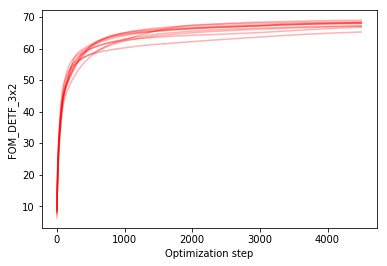

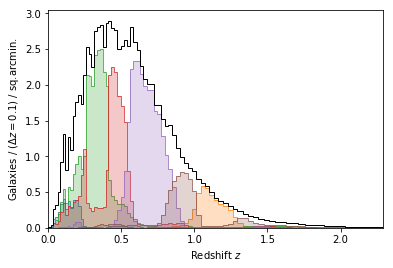

Running job with {'groups': 'group_cos_80_75', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=75.163 (max=75.169) after 1500 steps.
  score=76.981 (max=77.024) after 3000 steps.
  score=77.654 (max=77.666) after 4500 steps.
  score=78.023 (max=78.037) after 6000 steps.
trial 1/10: score=78.023 (max=78.037) after 6000 steps.
  score=73.759 (max=78.037) after 1500 steps.
  score=75.640 (max=78.037) after 3000 steps.
  score=76.190 (max=78.037) after 4500 steps.
  score=76.469 (max=78.037) after 6000 steps.
trial 2/10: score=76.469 (max=78.037) after 6000 steps.
  score=75.780 (max=78.037) after 1500 steps.
  score=77.909 (max=78.037) after 3000 steps.
  score=78.883 (max=78.940) after 4500 steps.
  score=79.455 (max=79.536) after 6000 steps.
trial 3/10: score=79.455 (max=79.536) after 6000 steps.
  score=72.071 (max=79.536) after 1500 steps.
  score=74.680 (max=79.536) after 3000 steps.
  score=

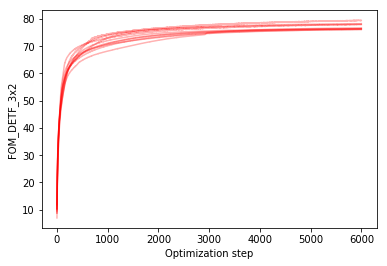

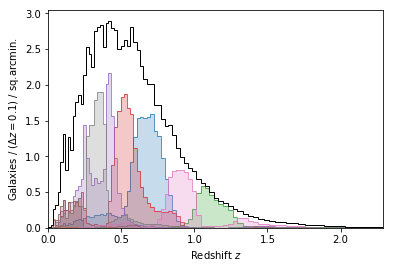

Running job with {'groups': 'group_cos_80_75', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=83.848 (max=83.872) after 1875 steps.
  score=85.905 (max=85.920) after 3750 steps.
  score=86.572 (max=86.575) after 5625 steps.
  score=86.863 (max=86.886) after 7500 steps.
trial 1/10: score=86.863 (max=86.886) after 7500 steps.
  score=81.477 (max=86.886) after 1875 steps.
  score=83.910 (max=86.886) after 3750 steps.
  score=85.015 (max=86.886) after 5625 steps.
  score=85.649 (max=86.886) after 7500 steps.
trial 2/10: score=85.649 (max=86.886) after 7500 steps.
  score=81.270 (max=86.886) after 1875 steps.
  score=84.719 (max=86.886) after 3750 steps.
  score=86.242 (max=86.886) after 5625 steps.
  score=86.912 (max=86.943) after 7500 steps.
trial 3/10: score=86.912 (max=86.943) after 7500 steps.
  score=79.942 (max=86.943) after 1875 steps.
  score=83.186 (max=86.943) after 3750 steps.
  score

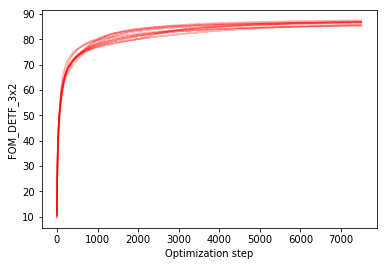

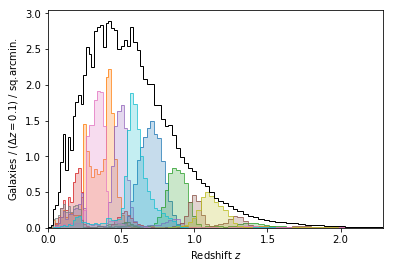

In [42]:
run_study('results/cos-75-detf', optimize_bins)

Running job with {'groups': 'group_cos_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=942.708 (max=942.708) after 375 steps.
  score=947.111 (max=947.111) after 750 steps.
  score=948.532 (max=948.532) after 1125 steps.
  score=949.395 (max=949.395) after 1500 steps.
trial 1/10: score=949.395 (max=949.395) after 1500 steps.
  score=936.098 (max=949.395) after 375 steps.
  score=941.027 (max=949.395) after 750 steps.
  score=942.579 (max=949.395) after 1125 steps.
  score=943.296 (max=949.395) after 1500 steps.
trial 2/10: score=943.296 (max=949.395) after 1500 steps.
  score=936.822 (max=949.395) after 375 steps.
  score=941.858 (max=949.395) after 750 steps.
  score=943.561 (max=949.395) after 1125 steps.
  score=944.268 (max=949.395) after 1500 steps.
trial 3/10: score=944.268 (max=949.395) after 1500 steps.
  score=944.538 (max=949.395) after 375 steps.
  score=949.877 (max=949.877) aft

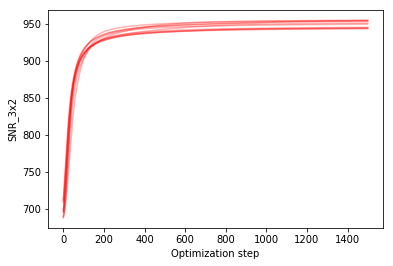

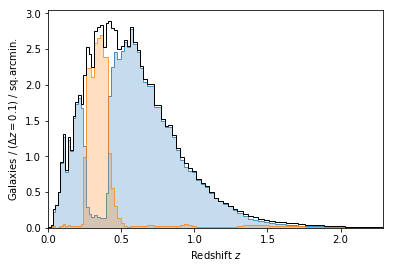

Running job with {'groups': 'group_cos_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1291.276 (max=1291.276) after 750 steps.
  score=1302.706 (max=1302.706) after 1500 steps.
  score=1308.450 (max=1308.450) after 2250 steps.
  score=1310.047 (max=1310.047) after 3000 steps.
trial 1/10: score=1310.047 (max=1310.047) after 3000 steps.
  score=1297.611 (max=1310.047) after 750 steps.
  score=1308.905 (max=1310.047) after 1500 steps.
  score=1311.815 (max=1311.815) after 2250 steps.
  score=1313.294 (max=1313.294) after 3000 steps.
trial 2/10: score=1313.294 (max=1313.294) after 3000 steps.
  score=1295.923 (max=1313.294) after 750 steps.
  score=1307.775 (max=1313.294) after 1500 steps.
  score=1310.773 (max=1313.294) after 2250 steps.
  score=1311.989 (max=1313.294) after 3000 steps.
trial 3/10: score=1311.989 (max=1313.294) after 3000 steps.
  score=1300.240 (max=1313.294) after 750 steps

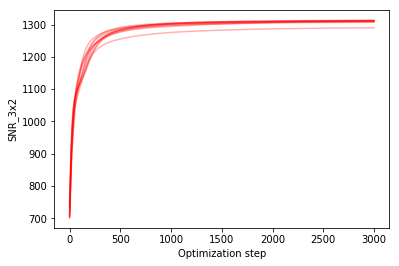

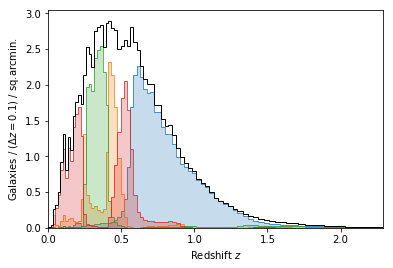

Running job with {'groups': 'group_cos_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1519.549 (max=1519.549) after 1125 steps.
  score=1542.334 (max=1542.334) after 2250 steps.
  score=1546.180 (max=1546.180) after 3375 steps.
  score=1548.208 (max=1548.208) after 4500 steps.
trial 1/10: score=1548.208 (max=1548.208) after 4500 steps.
  score=1524.515 (max=1548.208) after 1125 steps.
  score=1538.709 (max=1548.208) after 2250 steps.
  score=1542.005 (max=1548.208) after 3375 steps.
  score=1543.316 (max=1548.208) after 4500 steps.
trial 2/10: score=1543.316 (max=1548.208) after 4500 steps.
  score=1534.075 (max=1548.208) after 1125 steps.
  score=1550.952 (max=1550.952) after 2250 steps.
  score=1554.652 (max=1554.652) after 3375 steps.
  score=1555.981 (max=1555.981) after 4500 steps.
trial 3/10: score=1555.981 (max=1555.981) after 4500 steps.
  score=1529.539 (max=1555.981) after 1125 s

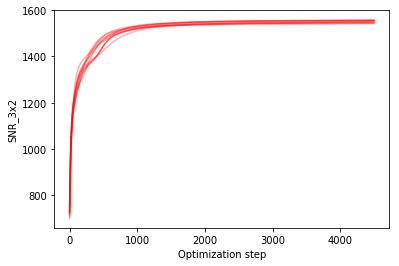

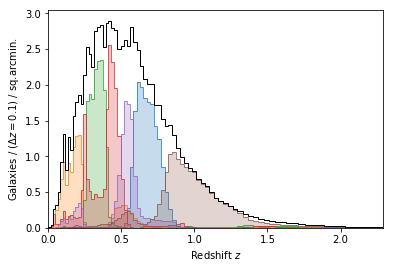

Running job with {'groups': 'group_cos_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1693.133 (max=1693.133) after 1500 steps.
  score=1719.578 (max=1719.578) after 3000 steps.
  score=1723.956 (max=1723.961) after 4500 steps.
  score=1726.375 (max=1726.379) after 6000 steps.
trial 1/10: score=1726.375 (max=1726.379) after 6000 steps.
  score=1693.027 (max=1726.379) after 1500 steps.
  score=1715.803 (max=1726.379) after 3000 steps.
  score=1719.771 (max=1726.379) after 4500 steps.
  score=1721.142 (max=1726.379) after 6000 steps.
trial 2/10: score=1721.142 (max=1726.379) after 6000 steps.
  score=1695.484 (max=1726.379) after 1500 steps.
  score=1713.672 (max=1726.379) after 3000 steps.
  score=1717.326 (max=1726.379) after 4500 steps.
  score=1718.602 (max=1726.379) after 6000 steps.
trial 3/10: score=1718.602 (max=1726.379) after 6000 steps.
  score=1703.383 (max=1726.379) after 1500 s

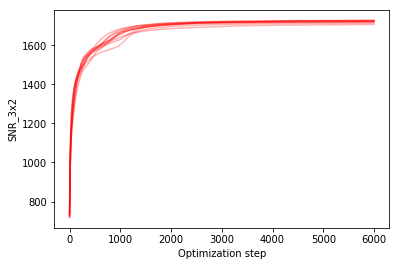

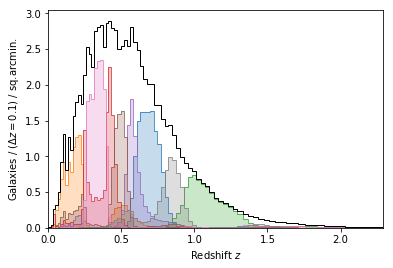

Running job with {'groups': 'group_cos_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1770.638 (max=1770.638) after 1875 steps.
  score=1824.273 (max=1824.273) after 3750 steps.
  score=1831.909 (max=1831.938) after 5625 steps.
  score=1833.583 (max=1833.604) after 7500 steps.
trial 1/10: score=1833.583 (max=1833.604) after 7500 steps.
  score=1804.101 (max=1833.604) after 1875 steps.
  score=1833.209 (max=1833.604) after 3750 steps.
  score=1838.166 (max=1838.166) after 5625 steps.
  score=1839.371 (max=1839.371) after 7500 steps.
trial 2/10: score=1839.371 (max=1839.371) after 7500 steps.
  score=1820.084 (max=1839.371) after 1875 steps.
  score=1841.565 (max=1841.565) after 3750 steps.
  score=1845.455 (max=1845.455) after 5625 steps.
  score=1846.651 (max=1846.651) after 7500 steps.
trial 3/10: score=1846.651 (max=1846.651) after 7500 steps.
  score=1776.626 (max=1846.651) after 1875 

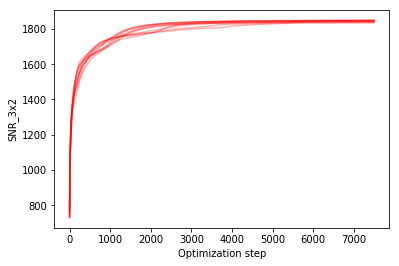

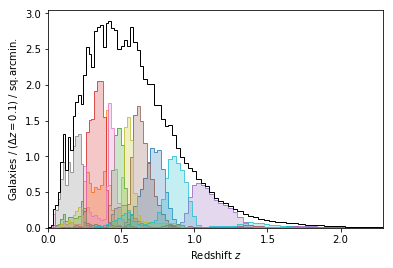

In [43]:
run_study('results/cos-150-snr', optimize_bins)

Running job with {'groups': 'group_cos_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=628.692 (max=628.692) after 375 steps.
  score=651.305 (max=651.305) after 750 steps.
  score=676.604 (max=676.604) after 1125 steps.
  score=683.970 (max=684.079) after 1500 steps.
trial 1/10: score=683.970 (max=684.079) after 1500 steps.
  score=1094.366 (max=1094.366) after 375 steps.
  score=1143.313 (max=1143.313) after 750 steps.
  score=1152.242 (max=1152.251) after 1125 steps.
  score=1155.125 (max=1155.199) after 1500 steps.
trial 2/10: score=1155.125 (max=1155.199) after 1500 steps.
  score=737.999 (max=1155.199) after 375 steps.
  score=796.854 (max=1155.199) after 750 steps.
  score=842.630 (max=1155.199) after 1125 steps.
  score=850.908 (max=1155.199) after 1500 steps.
trial 3/10: score=850.908 (max=1155.199) after 1500 steps.
  score=1092.444 (max=1155.199) after 375 steps.
  score=1180.203

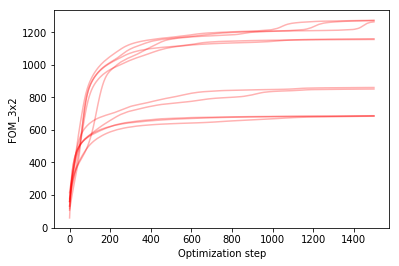

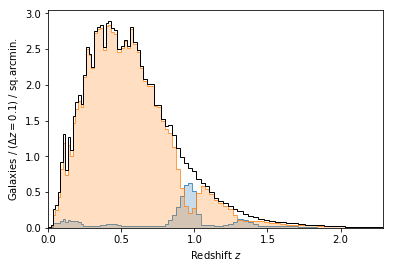

Running job with {'groups': 'group_cos_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=2557.606 (max=2557.606) after 750 steps.
  score=2625.552 (max=2625.636) after 1500 steps.
  score=2637.777 (max=2637.777) after 2250 steps.
  score=2651.751 (max=2651.821) after 3000 steps.
trial 1/10: score=2651.751 (max=2651.821) after 3000 steps.
  score=3088.842 (max=3090.877) after 750 steps.
  score=3438.333 (max=3439.120) after 1500 steps.
  score=3472.220 (max=3472.220) after 2250 steps.
  score=3490.682 (max=3492.919) after 3000 steps.
trial 2/10: score=3490.682 (max=3492.919) after 3000 steps.
  score=2269.160 (max=3492.919) after 750 steps.
  score=2358.375 (max=3492.919) after 1500 steps.
  score=2472.286 (max=3492.919) after 2250 steps.
  score=2509.807 (max=3492.919) after 3000 steps.
trial 3/10: score=2509.807 (max=3492.919) after 3000 steps.
  score=2605.322 (max=3492.919) after 750 steps

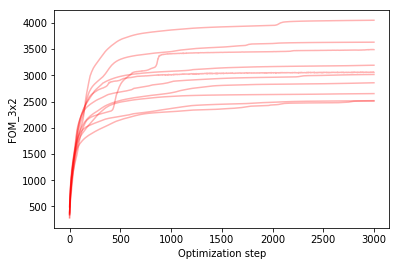

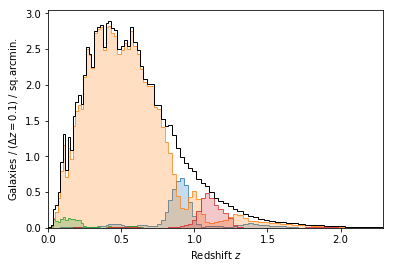

Running job with {'groups': 'group_cos_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=4767.179 (max=4768.056) after 1125 steps.
  score=4834.846 (max=4834.937) after 2250 steps.
  score=4866.367 (max=4866.847) after 3375 steps.
  score=4890.997 (max=4891.717) after 4500 steps.
trial 1/10: score=4890.997 (max=4891.717) after 4500 steps.
  score=4736.524 (max=4891.717) after 1125 steps.
  score=4900.524 (max=4901.367) after 2250 steps.
  score=4952.471 (max=4953.296) after 3375 steps.
  score=4999.146 (max=4999.704) after 4500 steps.
trial 2/10: score=4999.146 (max=4999.704) after 4500 steps.
  score=4757.829 (max=4999.704) after 1125 steps.
  score=5130.849 (max=5131.779) after 2250 steps.
  score=5233.356 (max=5233.931) after 3375 steps.
  score=5295.909 (max=5295.979) after 4500 steps.
trial 3/10: score=5295.909 (max=5295.979) after 4500 steps.
  score=5097.724 (max=5295.979) after 1125 s

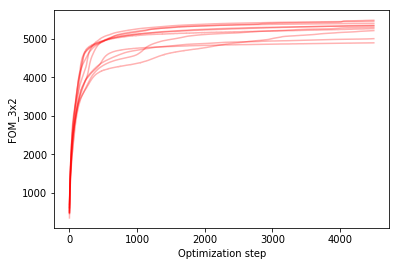

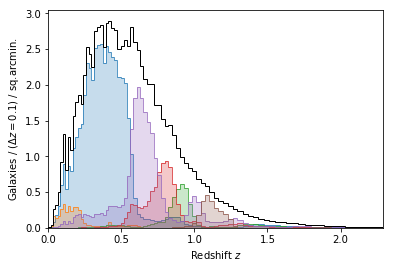

Running job with {'groups': 'group_cos_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=5797.481 (max=5797.547) after 1500 steps.
  score=5905.407 (max=5905.407) after 3000 steps.
  score=5949.309 (max=5949.860) after 4500 steps.
  score=5972.938 (max=5973.792) after 6000 steps.
trial 1/10: score=5972.938 (max=5973.792) after 6000 steps.
  score=6058.998 (max=6060.216) after 1500 steps.
  score=6185.298 (max=6185.298) after 3000 steps.
  score=6236.504 (max=6239.290) after 4500 steps.
  score=6272.706 (max=6274.130) after 6000 steps.
trial 2/10: score=6272.706 (max=6274.130) after 6000 steps.
  score=6513.103 (max=6513.136) after 1500 steps.
  score=6633.807 (max=6634.304) after 3000 steps.
  score=6679.380 (max=6680.286) after 4500 steps.
  score=6704.885 (max=6707.529) after 6000 steps.
trial 3/10: score=6704.885 (max=6707.529) after 6000 steps.
  score=6681.690 (max=6707.529) after 1500 s

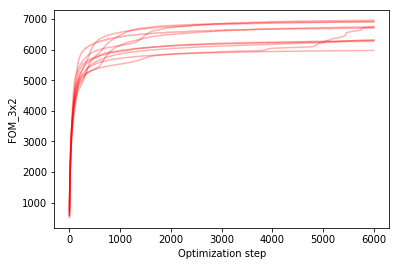

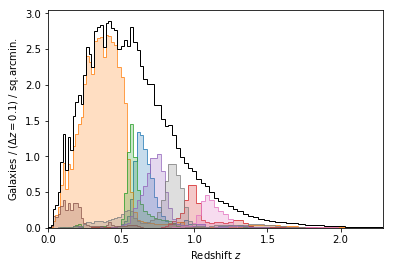

Running job with {'groups': 'group_cos_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=7285.607 (max=7285.607) after 1875 steps.
  score=7468.457 (max=7469.752) after 3750 steps.
  score=7558.471 (max=7561.066) after 5625 steps.
  score=7601.975 (max=7603.190) after 7500 steps.
trial 1/10: score=7601.975 (max=7603.190) after 7500 steps.
  score=7246.026 (max=7603.190) after 1875 steps.
  score=7442.575 (max=7603.190) after 3750 steps.
  score=7508.933 (max=7603.190) after 5625 steps.
  score=7538.330 (max=7603.190) after 7500 steps.
trial 2/10: score=7538.330 (max=7603.190) after 7500 steps.
  score=7374.828 (max=7603.190) after 1875 steps.
  score=7494.766 (max=7603.190) after 3750 steps.
  score=7546.178 (max=7603.190) after 5625 steps.
  score=7567.328 (max=7603.190) after 7500 steps.
trial 3/10: score=7567.328 (max=7603.190) after 7500 steps.
  score=7207.866 (max=7603.190) after 1875 

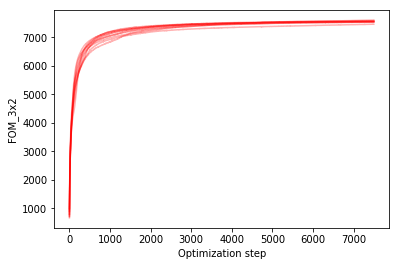

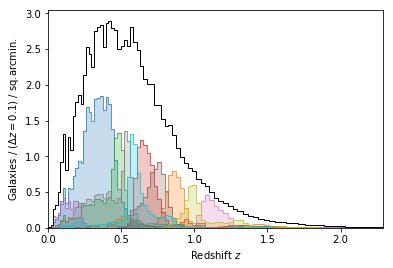

In [44]:
run_study('results/cos-150-fom', optimize_bins)

## Optimize Neural Network Classifier

Only load one of these if GPU memory is tight:

In [27]:
ndata = 2000000
with np.load('uniform_buz_riz.npz') as keys:
    Xbuz = jnp.array(3 * (keys['uniform'][:ndata] - 0.5))
    zbuz = jnp.array(keys['redshift'][:ndata])
print(f'Loaded {len(Xbuz)} Buzzard training samples with ~uniform distribution.')

Loaded 2000000 training samples with ~uniform distribution.


In [ ]:
ndata = 2000000
with np.load('uniform_dc2_riz.npz') as keys:
    Xdc2 = jnp.array(3 * (keys['uniform'][:ndata] - 0.5))
    zdc2 = jnp.array(keys['redshift'][:ndata])
print(f'Loaded {len(Xdc2)} DC2 training samples with ~uniform distribution.')

Learn a dense classifier using jax to build and optimize the network:

In [32]:
def learn_nnet(nbin=2, sample='buzzard', trainfrac=0.5, nhidden=64, nlayer=2, ntrial=1, nepoch=100, batchsize=50000, interval=10, eta=0.001,
               init_data=init_data, metric='FOM_DETF_3x2', gals_per_arcmin2=20., fsky=0.25, seed=123):
    """
    """
    if sample == 'buzzard':
        X, z = Xbuz, zbuz
    elif sample == 'dc2':
        X, z = Xdc2, zdc2
    else:
        raise ValueError(f'Invalid sample: "{sample}".')
    zedges = init_data[0].copy()
    # Include any overflow in the last bin.
    zedges[-1] = max(zedges[-1], z.max() + 1e-3)
    zedges = jnp.array(zedges)
    # Calculate the normalized dndz for each bin.
    def hist1bin(z, w):
        return jnp.histogram(z, bins=zedges, weights=w)[0]
    histbins = jax.vmap(hist1bin, in_axes=(None, 1), out_axes=0)
    
    # Build the network model.
    layers = []
    for i in range(nlayer):
        layers.extend([
            stax.Dense(nhidden),
            stax.LeakyRelu,
            stax.BatchNorm(axis=(0,1)),
        ])
    layers.extend([
        stax.Dense(nbin),
        stax.Softmax
    ])
    init_fun, apply_fun = stax.serial(*layers)
    
    def get_weights(params, Xb, zb):
        # Get normalized weights from the network model.
        wgts = apply_fun(params, Xb)
        # Convert to a normalized dndz for each bin.
        w = histbins(zb, wgts)
        return w / zb.shape[0]        
    
    # Evaluate all 3x2 metrics.
    def metrics(params, Xb, zb):
        w = get_weights(params, Xb, zb)
        # Use the same binning for number density and weak lensing.
        weights = jnp.array([w, w])
        return reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2, fsky)
    
    # Evaluate the loss as -metric.
    def loss(params, Xb, zb):
        return -metrics(params, Xb, zb)[metric]
    
    opt_init, opt_update, get_params = optimizers.adam(eta)
    
    # Define the update rule.
    @jax.jit
    def update(i, opt_state, Xb, zb):
        params = get_params(opt_state)
        grads = jax.grad(loss)(params, Xb, zb)
        return opt_update(i, grads, opt_state)
    
    rng = jax.random.PRNGKey(seed)
    gen = np.random.RandomState(seed)
    
    ndata = X.shape[0]
    ntrain = int(np.round(ndata * trainfrac))
    Xtrain, ztrain = X[:ntrain], z[:ntrain]
    Xvalid, zvalid = X[ntrain:], z[ntrain:]
    nbatch = ntrain // batchsize
    
    all_scores = []
    max_score = -1
    best_params = None
    
    for trial in range(ntrial):
    
        _, init_params = init_fun(rng, (batchsize, X.shape[1]))
        opt_state = opt_init(init_params)

        all_scores.append([])
        itercount = itertools.count()
        for epoch in range(nepoch):
            perm = gen.permutation(ntrain)
            for batch in range(nbatch):
                idx = perm[batch * batchsize:(batch + 1) * batchsize]
                opt_state = update(next(itercount), opt_state, Xtrain[idx], ztrain[idx])
            # Calculate train and validation scores after this epoch.
            params = get_params(opt_state)
            train_score = metrics(params, Xtrain, ztrain)[metric]
            all_scores[-1].append(train_score)
            if train_score > max_score:
                best_params = params
                max_score = train_score
            if epoch % interval == 0:
                valid_score = metrics(params, Xvalid, zvalid)[metric]
                print(f'Trial {trial+1}/{ntrial} epoch {epoch+1}/{nepoch} train {train_score:.3f} (max {max_score:.3f}) validation {valid_score:.3f}.')

    # Calculate all metrics for the best params.
    best_scores = metrics(best_params, Xtrain, ztrain)
    best_scores = {metric: float(value) for metric, value in best_scores.items()}
    
    # Convert the best parameters to normalized dndz weights.
    dndz_bin = get_weights(best_params, Xtrain, ztrain)

    return best_scores, dndz_bin, all_scores

Starting job at 2020-09-12 22:17:03.700759 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 19.398 (max 19.398) validation 19.421.
Trial 1/3 epoch 11/100 train 20.665 (max 20.665) validation 20.675.
Trial 1/3 epoch 21/100 train 20.726 (max 20.726) validation 20.731.
Trial 1/3 epoch 31/100 train 20.740 (max 20.753) validation 20.737.
Trial 1/3 epoch 41/100 train 20.781 (max 20.781) validation 20.787.
Trial 1/3 epoch 51/100 train 20.786 (max 20.798) validation 20.782.
Trial 1/3 epoch 61/100 train 20.825 (max 20.825) validation 20.830.
Trial 1/3 epoch 71/100 train 20.921 (max 20.921) validation 20.909.
Trial 1/3 epoch 81/100 train 20.952 (max 20.952) validation 20.928.
Trial 1/3 epoch 91/100 train 20.861 (max 20.957) validation 20.837.
Trial 2/3 epoch 1/100 train 19.412 (max 20.957) validation 19.437.
Trial 2/3 epoch 11/100 train 20.654 (max 20.957) 

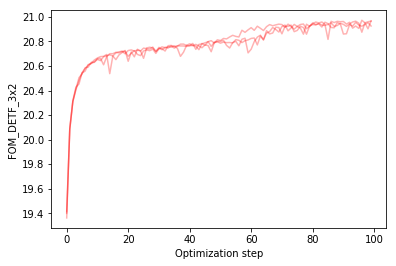

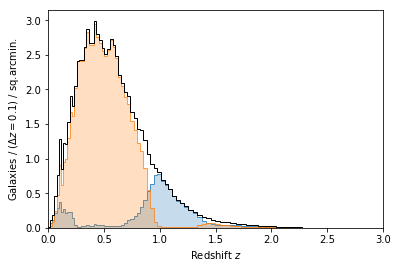

Starting job at 2020-09-12 22:19:07.281460 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 49.413 (max 49.413) validation 49.725.
Trial 1/3 epoch 11/100 train 56.970 (max 56.970) validation 57.202.
Trial 1/3 epoch 21/100 train 57.309 (max 57.434) validation 57.540.
Trial 1/3 epoch 31/100 train 57.662 (max 57.662) validation 57.794.
Trial 1/3 epoch 41/100 train 57.911 (max 58.011) validation 58.087.
Trial 1/3 epoch 51/100 train 58.081 (max 58.164) validation 58.190.
Trial 1/3 epoch 61/100 train 58.250 (max 58.288) validation 58.336.
Trial 1/3 epoch 71/100 train 58.341 (max 58.341) validation 58.362.
Trial 1/3 epoch 81/100 train 58.299 (max 58.403) validation 58.393.
Trial 1/3 epoch 91/100 train 57.979 (max 58.438) validation 57.980.
Trial 2/3 epoch 1/100 train 49.462 (max 58.470) validation 49.774.
Trial 2/3 epoch 11/100 train 56.952 (max 58.470) 

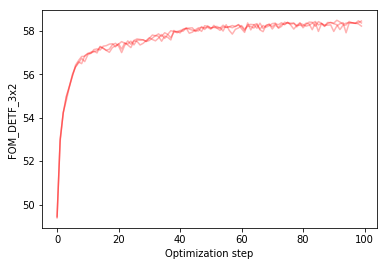

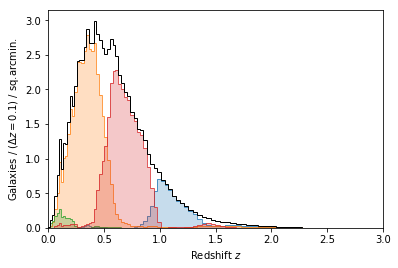

Starting job at 2020-09-12 22:21:30.563727 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 58.212 (max 58.212) validation 58.604.
Trial 1/3 epoch 11/100 train 71.859 (max 71.859) validation 72.201.
Trial 1/3 epoch 21/100 train 72.660 (max 72.660) validation 72.905.
Trial 1/3 epoch 31/100 train 73.723 (max 73.723) validation 73.739.
Trial 1/3 epoch 41/100 train 73.364 (max 73.877) validation 73.511.
Trial 1/3 epoch 51/100 train 73.972 (max 74.044) validation 74.009.
Trial 1/3 epoch 61/100 train 73.974 (max 74.123) validation 74.067.
Trial 1/3 epoch 71/100 train 74.093 (max 74.169) validation 74.074.
Trial 1/3 epoch 81/100 train 74.069 (max 74.207) validation 74.210.
Trial 1/3 epoch 91/100 train 74.246 (max 74.279) validation 74.271.
Trial 2/3 epoch 1/100 train 58.293 (max 74.279) validation 58.709.
Trial 2/3 epoch 11/100 train 71.712 (max 74.279) 

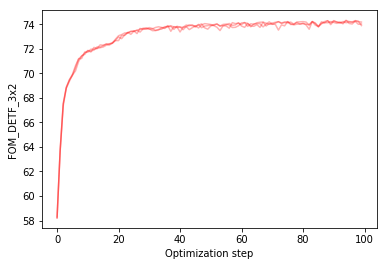

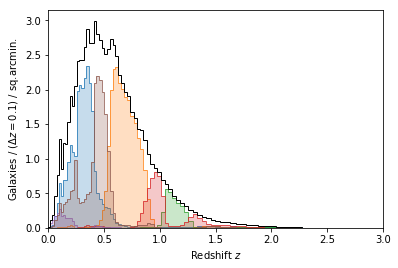

Starting job at 2020-09-12 22:25:41.780151 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 65.843 (max 65.843) validation 66.577.
Trial 1/3 epoch 11/100 train 82.326 (max 82.326) validation 83.020.
Trial 1/3 epoch 21/100 train 83.409 (max 83.514) validation 84.123.
Trial 1/3 epoch 31/100 train 83.820 (max 83.986) validation 84.217.
Trial 1/3 epoch 41/100 train 84.558 (max 84.558) validation 85.199.
Trial 1/3 epoch 51/100 train 85.674 (max 85.674) validation 85.916.
Trial 1/3 epoch 61/100 train 86.310 (max 86.310) validation 86.703.
Trial 1/3 epoch 71/100 train 86.171 (max 86.481) validation 86.654.
Trial 1/3 epoch 81/100 train 86.602 (max 86.646) validation 86.823.
Trial 1/3 epoch 91/100 train 86.682 (max 86.682) validation 86.951.
Trial 2/3 epoch 1/100 train 66.048 (max 86.736) validation 66.754.
Trial 2/3 epoch 11/100 train 82.308 (max 86.736) 

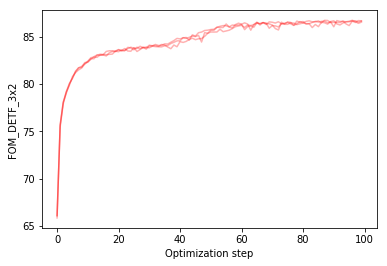

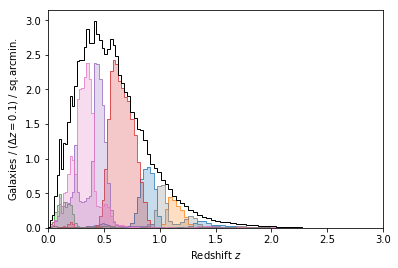

Starting job at 2020-09-12 22:30:50.838107 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 73.482 (max 73.482) validation 74.040.
Trial 1/3 epoch 11/100 train 91.420 (max 91.420) validation 91.910.
Trial 1/3 epoch 21/100 train 92.972 (max 92.972) validation 93.508.
Trial 1/3 epoch 31/100 train 93.507 (max 93.541) validation 93.715.
Trial 1/3 epoch 41/100 train 93.900 (max 93.900) validation 94.543.
Trial 1/3 epoch 51/100 train 94.495 (max 94.601) validation 94.866.
Trial 1/3 epoch 61/100 train 94.699 (max 94.795) validation 95.064.
Trial 1/3 epoch 71/100 train 94.734 (max 95.098) validation 95.364.
Trial 1/3 epoch 81/100 train 95.175 (max 95.175) validation 95.543.
Trial 1/3 epoch 91/100 train 95.057 (max 95.308) validation 95.376.
Trial 2/3 epoch 1/100 train 73.196 (max 95.361) validation 73.724.
Trial 2/3 epoch 11/100 train 91.569 (max 95.361)

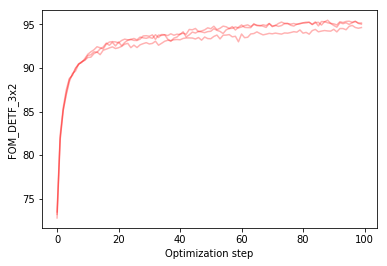

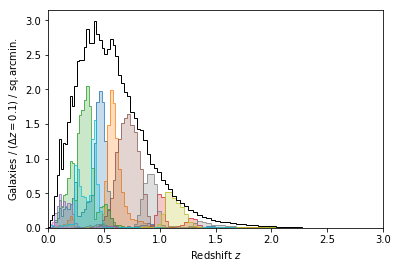

In [29]:
run_study('results/nn-3-64-detf', learn_nnet, rerun='all')

Starting job at 2020-09-12 22:39:10.552197 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 948.400 (max 948.400) validation 948.283.
Trial 1/3 epoch 11/100 train 955.763 (max 955.763) validation 955.679.
Trial 1/3 epoch 21/100 train 956.287 (max 956.287) validation 956.147.
Trial 1/3 epoch 31/100 train 956.461 (max 956.477) validation 956.297.
Trial 1/3 epoch 41/100 train 956.613 (max 956.613) validation 956.429.
Trial 1/3 epoch 51/100 train 956.672 (max 956.672) validation 956.508.
Trial 1/3 epoch 61/100 train 956.704 (max 956.710) validation 956.557.
Trial 1/3 epoch 71/100 train 956.753 (max 956.753) validation 956.585.
Trial 1/3 epoch 81/100 train 956.723 (max 956.753) validation 956.569.
Trial 1/3 epoch 91/100 train 956.757 (max 956.784) validation 956.588.
Trial 2/3 epoch 1/100 train 948.385 (max 956.792) validation 948.268.
Trial 2/3 epoch 11/10

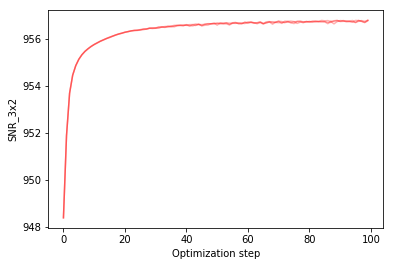

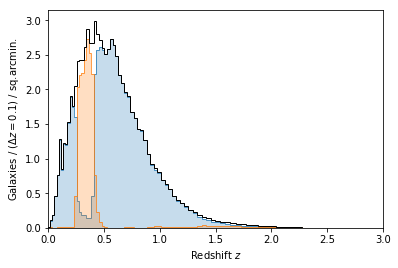

Starting job at 2020-09-12 22:40:54.025458 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1267.832 (max 1267.832) validation 1268.195.
Trial 1/3 epoch 11/100 train 1314.236 (max 1314.236) validation 1313.982.
Trial 1/3 epoch 21/100 train 1317.862 (max 1317.862) validation 1317.638.
Trial 1/3 epoch 31/100 train 1320.929 (max 1320.929) validation 1320.802.
Trial 1/3 epoch 41/100 train 1322.005 (max 1322.005) validation 1321.840.
Trial 1/3 epoch 51/100 train 1322.456 (max 1322.682) validation 1322.347.
Trial 1/3 epoch 61/100 train 1322.925 (max 1323.094) validation 1322.698.
Trial 1/3 epoch 71/100 train 1323.226 (max 1323.285) validation 1323.085.
Trial 1/3 epoch 81/100 train 1323.409 (max 1323.477) validation 1323.209.
Trial 1/3 epoch 91/100 train 1323.503 (max 1323.546) validation 1323.213.
Trial 2/3 epoch 1/100 train 1269.807 (max 1323.654) validatio

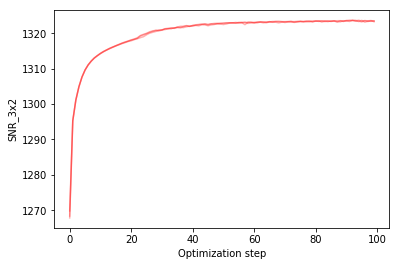

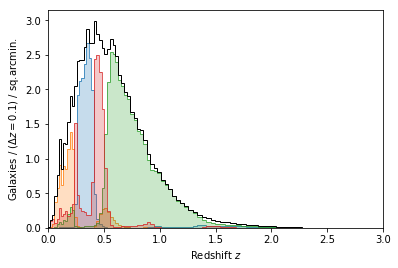

Starting job at 2020-09-12 22:43:09.085595 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1486.198 (max 1486.198) validation 1486.934.
Trial 1/3 epoch 11/100 train 1556.237 (max 1556.237) validation 1555.893.
Trial 1/3 epoch 21/100 train 1563.491 (max 1563.491) validation 1563.112.
Trial 1/3 epoch 31/100 train 1567.106 (max 1567.106) validation 1566.670.
Trial 1/3 epoch 41/100 train 1568.473 (max 1568.473) validation 1567.888.
Trial 1/3 epoch 51/100 train 1568.984 (max 1568.984) validation 1568.419.
Trial 1/3 epoch 61/100 train 1569.364 (max 1569.386) validation 1568.593.
Trial 1/3 epoch 71/100 train 1569.399 (max 1569.671) validation 1568.859.
Trial 1/3 epoch 81/100 train 1570.032 (max 1570.032) validation 1569.473.
Trial 1/3 epoch 91/100 train 1569.781 (max 1570.218) validation 1569.187.
Trial 2/3 epoch 1/100 train 1403.399 (max 1570.280) validatio

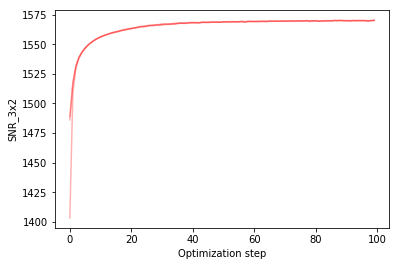

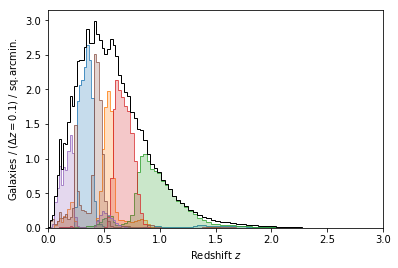

Starting job at 2020-09-12 22:47:10.303548 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1506.846 (max 1506.846) validation 1506.547.
Trial 1/3 epoch 11/100 train 1720.678 (max 1720.678) validation 1720.343.
Trial 1/3 epoch 21/100 train 1738.368 (max 1738.368) validation 1736.193.
Trial 1/3 epoch 31/100 train 1744.343 (max 1744.652) validation 1741.991.
Trial 1/3 epoch 41/100 train 1747.315 (max 1747.346) validation 1745.262.
Trial 1/3 epoch 51/100 train 1748.088 (max 1748.349) validation 1745.515.
Trial 1/3 epoch 61/100 train 1748.810 (max 1749.527) validation 1746.632.
Trial 1/3 epoch 71/100 train 1748.767 (max 1749.820) validation 1746.735.
Trial 1/3 epoch 81/100 train 1750.440 (max 1750.440) validation 1748.019.
Trial 1/3 epoch 91/100 train 1751.122 (max 1751.122) validation 1748.357.
Trial 2/3 epoch 1/100 train 1506.016 (max 1751.568) validatio

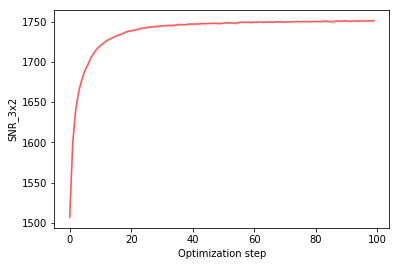

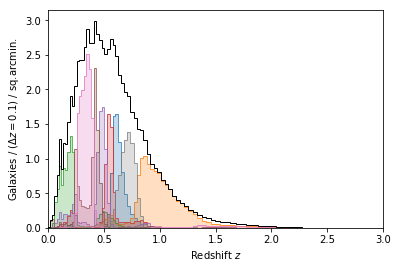

Starting job at 2020-09-12 22:52:04.790204 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1555.823 (max 1555.823) validation 1554.890.
Trial 1/3 epoch 11/100 train 1845.942 (max 1845.942) validation 1845.944.
Trial 1/3 epoch 21/100 train 1869.023 (max 1869.023) validation 1869.215.
Trial 1/3 epoch 31/100 train 1877.521 (max 1877.521) validation 1875.895.
Trial 1/3 epoch 41/100 train 1881.083 (max 1881.083) validation 1879.681.
Trial 1/3 epoch 51/100 train 1882.863 (max 1883.002) validation 1880.949.
Trial 1/3 epoch 61/100 train 1885.698 (max 1885.698) validation 1883.708.
Trial 1/3 epoch 71/100 train 1885.645 (max 1885.698) validation 1884.125.
Trial 1/3 epoch 81/100 train 1884.606 (max 1886.366) validation 1883.319.
Trial 1/3 epoch 91/100 train 1885.550 (max 1887.215) validation 1883.632.
Trial 2/3 epoch 1/100 train 1555.388 (max 1887.973) validati

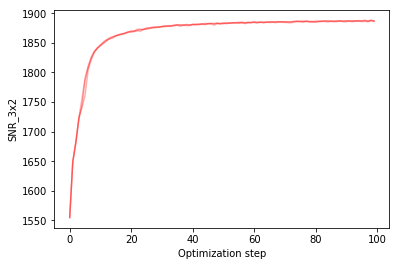

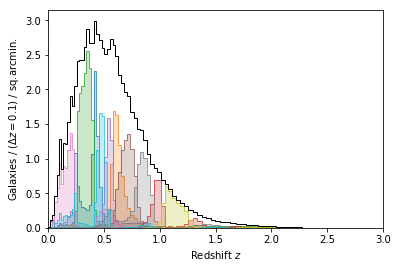

In [30]:
run_study('results/nn-3-64-snr', learn_nnet, rerun='all')

Starting job at 2020-09-12 23:00:01.928108 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 775.605 (max 775.605) validation 774.570.
Trial 1/3 epoch 11/100 train 869.893 (max 869.893) validation 864.829.
Trial 1/3 epoch 21/100 train 882.690 (max 882.690) validation 877.801.
Trial 1/3 epoch 31/100 train 880.754 (max 886.564) validation 874.982.
Trial 1/3 epoch 41/100 train 886.034 (max 890.684) validation 881.865.
Trial 1/3 epoch 51/100 train 890.753 (max 892.525) validation 887.577.
Trial 1/3 epoch 61/100 train 964.495 (max 964.495) validation 975.311.
Trial 1/3 epoch 71/100 train 1447.781 (max 1448.173) validation 1445.484.
Trial 1/3 epoch 81/100 train 1458.261 (max 1458.261) validation 1456.767.
Trial 1/3 epoch 91/100 train 1458.304 (max 1461.352) validation 1451.919.
Trial 2/3 epoch 1/100 train 768.294 (max 1463.356) validation 767.211.
Trial 2/3 e

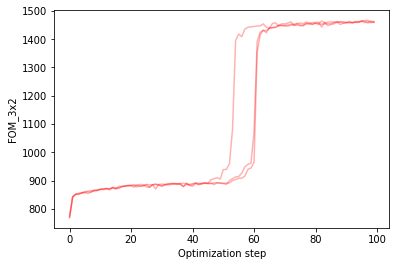

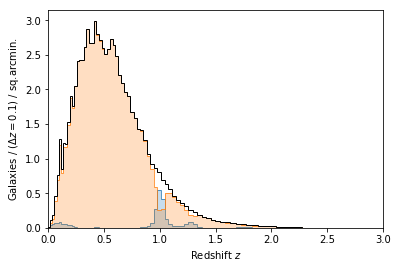

Starting job at 2020-09-12 23:01:52.541487 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 2913.357 (max 2913.357) validation 2958.175.
Trial 1/3 epoch 11/100 train 4707.096 (max 4725.474) validation 4760.229.
Trial 1/3 epoch 21/100 train 4791.318 (max 4816.029) validation 4825.261.
Trial 1/3 epoch 31/100 train 4770.809 (max 4850.739) validation 4826.844.
Trial 1/3 epoch 41/100 train 4888.569 (max 4895.175) validation 4932.147.
Trial 1/3 epoch 51/100 train 4881.520 (max 4903.903) validation 4902.426.
Trial 1/3 epoch 61/100 train 4906.280 (max 4921.064) validation 4936.100.
Trial 1/3 epoch 71/100 train 4877.058 (max 4921.064) validation 4905.409.
Trial 1/3 epoch 81/100 train 4860.528 (max 4921.069) validation 4887.105.
Trial 1/3 epoch 91/100 train 4828.999 (max 4924.871) validation 4861.112.
Trial 2/3 epoch 1/100 train 2921.198 (max 4924.871) validatio

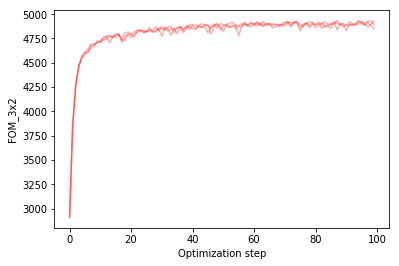

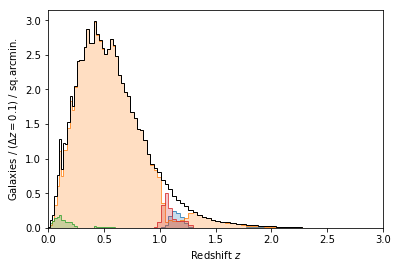

Starting job at 2020-09-12 23:04:10.942988 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 4181.422 (max 4181.422) validation 4211.771.
Trial 1/3 epoch 11/100 train 6299.246 (max 6299.246) validation 6344.228.
Trial 1/3 epoch 21/100 train 6526.049 (max 6547.632) validation 6574.230.
Trial 1/3 epoch 31/100 train 6516.808 (max 6564.400) validation 6556.880.
Trial 1/3 epoch 41/100 train 6624.081 (max 6624.081) validation 6648.193.
Trial 1/3 epoch 51/100 train 6652.012 (max 6652.012) validation 6681.391.
Trial 1/3 epoch 61/100 train 6672.864 (max 6672.864) validation 6696.017.
Trial 1/3 epoch 71/100 train 6658.574 (max 6706.543) validation 6695.710.
Trial 1/3 epoch 81/100 train 6700.208 (max 6706.543) validation 6706.958.
Trial 1/3 epoch 91/100 train 6710.740 (max 6712.455) validation 6728.138.
Trial 2/3 epoch 1/100 train 4176.600 (max 6726.534) validatio

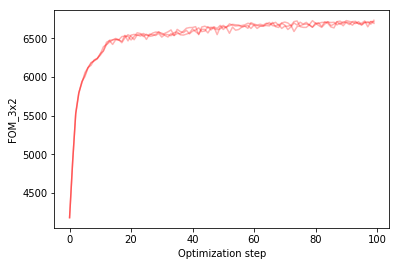

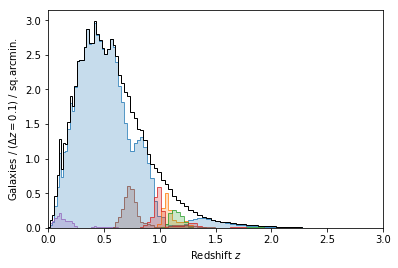

Starting job at 2020-09-12 23:08:17.327202 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 5013.593 (max 5013.593) validation 5048.176.
Trial 1/3 epoch 11/100 train 7896.958 (max 7896.958) validation 7923.149.
Trial 1/3 epoch 21/100 train 8068.116 (max 8069.316) validation 8084.660.
Trial 1/3 epoch 31/100 train 8212.672 (max 8226.210) validation 8238.260.
Trial 1/3 epoch 41/100 train 8283.474 (max 8321.733) validation 8308.554.
Trial 1/3 epoch 51/100 train 8377.552 (max 8377.552) validation 8375.603.
Trial 1/3 epoch 61/100 train 8321.495 (max 8389.312) validation 8336.571.
Trial 1/3 epoch 71/100 train 8366.206 (max 8415.348) validation 8375.955.
Trial 1/3 epoch 81/100 train 8411.801 (max 8423.232) validation 8415.139.
Trial 1/3 epoch 91/100 train 8378.080 (max 8429.661) validation 8363.135.
Trial 2/3 epoch 1/100 train 4909.804 (max 8446.237) validatio

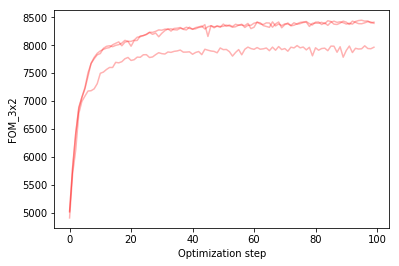

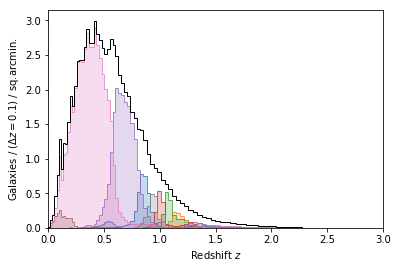

Starting job at 2020-09-12 23:13:22.237894 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 5844.549 (max 5844.549) validation 5909.237.
Trial 1/3 epoch 11/100 train 8733.253 (max 8733.253) validation 8835.086.
Trial 1/3 epoch 21/100 train 9375.204 (max 9375.204) validation 9456.288.
Trial 1/3 epoch 31/100 train 9456.054 (max 9456.054) validation 9528.402.
Trial 1/3 epoch 41/100 train 9516.016 (max 9516.016) validation 9616.854.
Trial 1/3 epoch 51/100 train 9607.989 (max 9617.377) validation 9665.704.
Trial 1/3 epoch 61/100 train 9643.322 (max 9660.470) validation 9706.016.
Trial 1/3 epoch 71/100 train 9635.297 (max 9685.415) validation 9686.430.
Trial 1/3 epoch 81/100 train 9675.971 (max 9693.639) validation 9711.479.
Trial 1/3 epoch 91/100 train 9726.772 (max 9726.772) validation 9785.827.
Trial 2/3 epoch 1/100 train 5820.187 (max 9747.117) validati

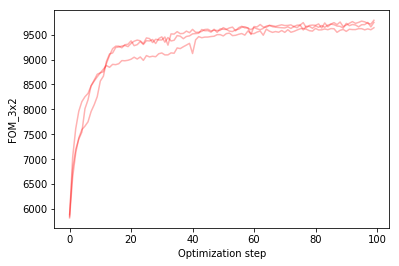

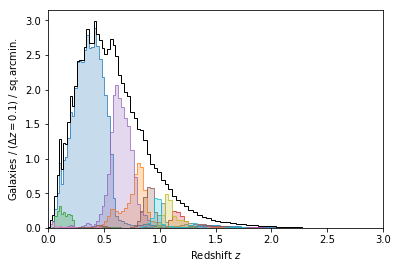

In [31]:
run_study('results/nn-3-64-fom', learn_nnet, rerun='all')

Skipping already completed job for nbin=2
Skipping already completed job for nbin=4
Starting job at 2020-09-11 14:47:58.476010 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 150, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 63.393 (max 63.393) validation 63.526.
Trial 1/3 epoch 11/200 train 71.397 (max 71.397) validation 71.440.
Trial 1/3 epoch 21/200 train 73.240 (max 73.240) validation 73.135.
Trial 1/3 epoch 31/200 train 73.761 (max 73.761) validation 73.742.
Trial 1/3 epoch 41/200 train 73.876 (max 73.948) validation 73.848.
Trial 1/3 epoch 51/200 train 73.916 (max 74.106) validation 73.909.
Trial 1/3 epoch 61/200 train 73.892 (max 74.160) validation 73.881.
Trial 1/3 epoch 71/200 train 74.085 (max 74.292) validation 73.967.
Trial 1/3 epoch 81/200 train 74.416 (max 74.478) validation 74.416.
Trial 1/3 epoch 91/200 train 74.620 (max 74.686) validation 74.578.
Trial 1/3 epoch 101/200 train 7

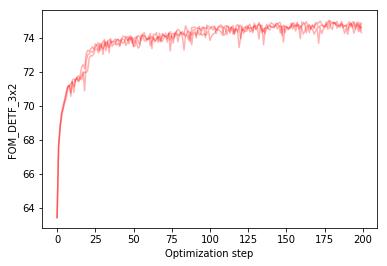

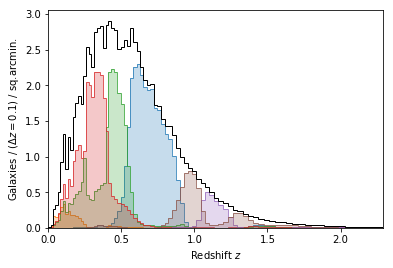

Starting job at 2020-09-11 14:58:20.382672 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 200, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 77.998 (max 77.998) validation 78.045.
Trial 1/3 epoch 11/200 train 83.989 (max 84.088) validation 84.053.
Trial 1/3 epoch 21/200 train 85.207 (max 85.207) validation 85.036.
Trial 1/3 epoch 31/200 train 85.564 (max 85.619) validation 85.445.
Trial 1/3 epoch 41/200 train 85.771 (max 85.924) validation 85.482.
Trial 1/3 epoch 51/200 train 86.158 (max 86.455) validation 86.029.
Trial 1/3 epoch 61/200 train 86.412 (max 86.539) validation 86.334.
Trial 1/3 epoch 71/200 train 86.575 (max 86.680) validation 86.583.
Trial 1/3 epoch 81/200 train 86.372 (max 86.680) validation 86.271.
Trial 1/3 epoch 91/200 train 86.706 (max 86.769) validation 86.594.
Trial 1/3 epoch 101/200 train 86.782 (max 86.784) validation 86.667.
Trial 1/3 epoch 111/200 train 86.574 (max 86.8

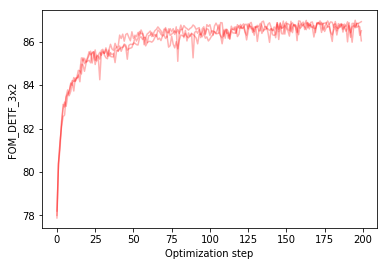

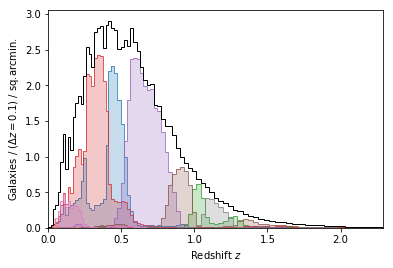

Starting job at 2020-09-11 15:11:39.733902 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 250, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 84.027 (max 84.027) validation 84.104.
Trial 1/3 epoch 11/200 train 94.238 (max 94.539) validation 94.506.
Trial 1/3 epoch 21/200 train 95.899 (max 96.360) validation 95.963.
Trial 1/3 epoch 31/200 train 96.806 (max 96.806) validation 96.950.
Trial 1/3 epoch 41/200 train 96.148 (max 97.194) validation 96.404.
Trial 1/3 epoch 51/200 train 97.020 (max 97.275) validation 97.052.
Trial 1/3 epoch 61/200 train 97.243 (max 97.455) validation 97.323.
Trial 1/3 epoch 71/200 train 96.953 (max 97.511) validation 96.858.
Trial 1/3 epoch 81/200 train 97.470 (max 97.511) validation 97.369.
Trial 1/3 epoch 91/200 train 97.364 (max 97.518) validation 97.385.
Trial 1/3 epoch 101/200 train 97.009 (max 97.552) validation 96.928.
Trial 1/3 epoch 111/200 train 97.680 (max 97.

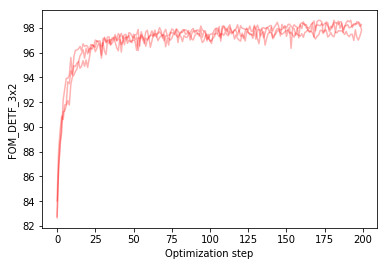

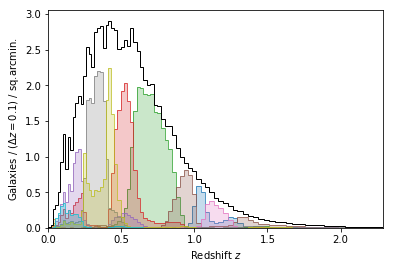

In [12]:
run_study('results/nn-3-detf', learn_nnet)

Starting job at 2020-09-11 16:16:09.533726 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 20.028 (max 20.028) validation 20.012.
Trial 1/3 epoch 11/200 train 20.672 (max 20.672) validation 20.644.
Trial 1/3 epoch 21/200 train 20.728 (max 20.728) validation 20.696.
Trial 1/3 epoch 31/200 train 20.703 (max 20.728) validation 20.670.
Trial 1/3 epoch 41/200 train 20.729 (max 20.757) validation 20.710.
Trial 1/3 epoch 51/200 train 20.870 (max 20.880) validation 20.814.
Trial 1/3 epoch 61/200 train 20.860 (max 20.910) validation 20.801.
Trial 1/3 epoch 71/200 train 20.917 (max 20.917) validation 20.858.
Trial 1/3 epoch 81/200 train 20.916 (max 20.923) validation 20.875.
Trial 1/3 epoch 91/200 train 20.882 (max 20.937) validation 20.812.
Trial 1/3 epoch 101/200 train 20.895 (max 20.937) validation 20.853.
Trial 1/3 epoch 111/200 train 20.910 (max 20.93

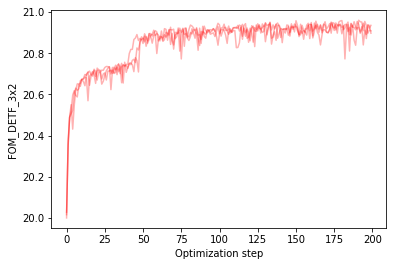

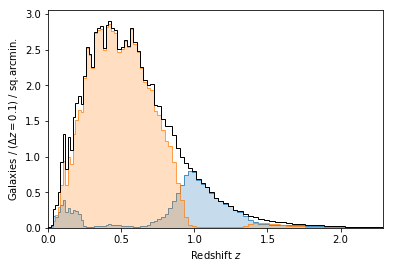

Starting job at 2020-09-11 16:20:07.058277 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 52.448 (max 52.448) validation 52.670.
Trial 1/3 epoch 11/200 train 57.097 (max 57.097) validation 57.134.
Trial 1/3 epoch 21/200 train 57.435 (max 57.459) validation 57.397.
Trial 1/3 epoch 31/200 train 58.125 (max 58.125) validation 58.010.
Trial 1/3 epoch 41/200 train 58.190 (max 58.190) validation 58.228.
Trial 1/3 epoch 51/200 train 58.173 (max 58.261) validation 58.057.
Trial 1/3 epoch 61/200 train 58.266 (max 58.309) validation 58.159.
Trial 1/3 epoch 71/200 train 57.976 (max 58.337) validation 57.957.
Trial 1/3 epoch 81/200 train 58.249 (max 58.337) validation 58.240.
Trial 1/3 epoch 91/200 train 58.426 (max 58.426) validation 58.295.
Trial 1/3 epoch 101/200 train 58.494 (max 58.494) validation 58.318.
Trial 1/3 epoch 111/200 train 58.424 (max 58.49

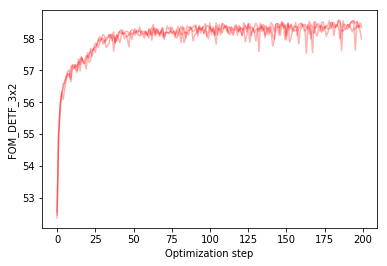

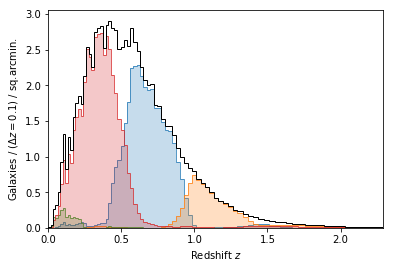

Starting job at 2020-09-11 16:25:11.594653 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 62.604 (max 62.604) validation 62.914.
Trial 1/3 epoch 11/200 train 71.628 (max 71.628) validation 71.563.
Trial 1/3 epoch 21/200 train 71.917 (max 72.027) validation 71.787.
Trial 1/3 epoch 31/200 train 72.587 (max 72.587) validation 72.322.
Trial 1/3 epoch 41/200 train 73.090 (max 73.090) validation 73.029.
Trial 1/3 epoch 51/200 train 73.247 (max 73.337) validation 73.293.
Trial 1/3 epoch 61/200 train 73.081 (max 73.357) validation 73.089.
Trial 1/3 epoch 71/200 train 73.317 (max 73.459) validation 73.418.
Trial 1/3 epoch 81/200 train 73.596 (max 73.596) validation 73.661.
Trial 1/3 epoch 91/200 train 73.575 (max 73.668) validation 73.600.
Trial 1/3 epoch 101/200 train 73.526 (max 73.680) validation 73.341.
Trial 1/3 epoch 111/200 train 73.677 (max 73.83

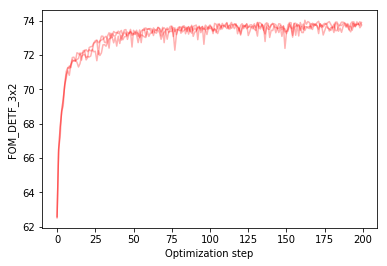

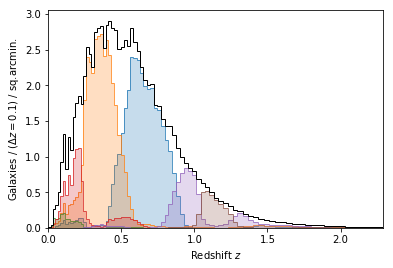

Starting job at 2020-09-11 16:33:43.687299 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 68.783 (max 68.783) validation 68.912.
Trial 1/3 epoch 11/200 train 83.427 (max 83.427) validation 83.512.
Trial 1/3 epoch 21/200 train 85.189 (max 85.189) validation 85.064.
Trial 1/3 epoch 31/200 train 86.329 (max 86.329) validation 86.381.
Trial 1/3 epoch 41/200 train 86.522 (max 86.639) validation 86.489.
Trial 1/3 epoch 51/200 train 86.695 (max 86.966) validation 86.640.
Trial 1/3 epoch 61/200 train 86.502 (max 86.966) validation 86.344.
Trial 1/3 epoch 71/200 train 86.845 (max 87.027) validation 86.917.
Trial 1/3 epoch 81/200 train 87.003 (max 87.153) validation 86.949.
Trial 1/3 epoch 91/200 train 86.652 (max 87.190) validation 86.505.
Trial 1/3 epoch 101/200 train 87.128 (max 87.282) validation 87.044.
Trial 1/3 epoch 111/200 train 87.218 (max 87.30

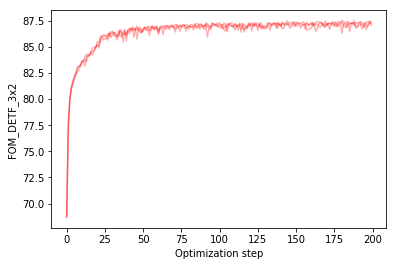

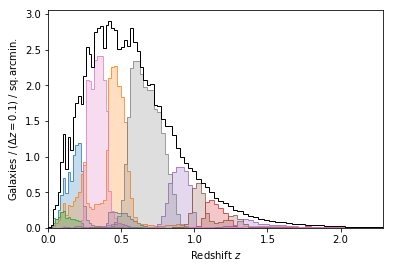

Starting job at 2020-09-11 16:44:08.125104 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 71.514 (max 71.514) validation 71.779.
Trial 1/3 epoch 11/200 train 92.433 (max 92.433) validation 92.402.
Trial 1/3 epoch 21/200 train 93.489 (max 93.489) validation 93.416.
Trial 1/3 epoch 31/200 train 93.950 (max 94.722) validation 94.132.
Trial 1/3 epoch 41/200 train 95.078 (max 95.508) validation 95.016.
Trial 1/3 epoch 51/200 train 95.627 (max 95.782) validation 95.616.
Trial 1/3 epoch 61/200 train 95.951 (max 96.105) validation 95.992.
Trial 1/3 epoch 71/200 train 96.072 (max 96.261) validation 96.070.
Trial 1/3 epoch 81/200 train 96.501 (max 96.722) validation 96.380.
Trial 1/3 epoch 91/200 train 96.484 (max 96.722) validation 96.426.
Trial 1/3 epoch 101/200 train 96.978 (max 96.978) validation 96.903.
Trial 1/3 epoch 111/200 train 96.773 (max 97.1

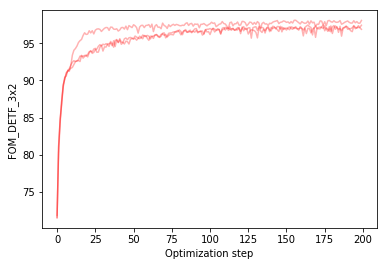

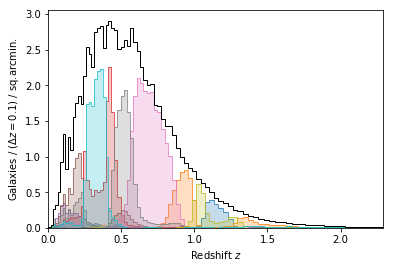

In [14]:
run_study('results/nn-4-64-detf', learn_nnet)

Starting job at 2020-09-11 17:00:48.616372 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 16.903 (max 16.903) validation 16.828.
Trial 1/3 epoch 11/100 train 19.442 (max 19.442) validation 19.411.
Trial 1/3 epoch 21/100 train 20.577 (max 20.577) validation 20.542.
Trial 1/3 epoch 31/100 train 20.600 (max 20.632) validation 20.564.
Trial 1/3 epoch 41/100 train 20.665 (max 20.665) validation 20.634.
Trial 1/3 epoch 51/100 train 20.695 (max 20.695) validation 20.670.
Trial 1/3 epoch 61/100 train 20.695 (max 20.710) validation 20.667.
Trial 1/3 epoch 71/100 train 20.709 (max 20.710) validation 20.674.
Trial 1/3 epoch 81/100 train 20.686 (max 20.722) validation 20.668.
Trial 1/3 epoch 91/100 train 20.702 (max 20.729) validation 20.679.
Trial 2/3 epoch 1/100 train 16.905 (max 20.731) validation 16.833.
Trial 2/3 epoch 11/100 train 19.618 (max 20.731) 

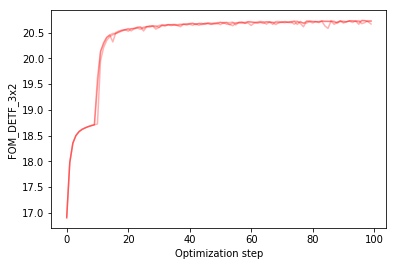

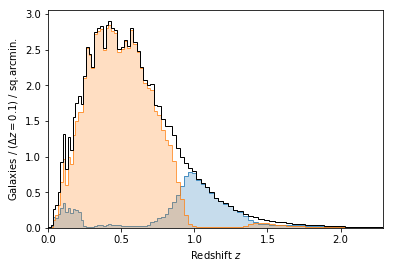

Starting job at 2020-09-11 17:02:29.794466 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 46.166 (max 46.166) validation 46.230.
Trial 1/3 epoch 11/100 train 55.865 (max 55.865) validation 56.004.
Trial 1/3 epoch 21/100 train 56.532 (max 56.783) validation 56.725.
Trial 1/3 epoch 31/100 train 57.014 (max 57.060) validation 57.045.
Trial 1/3 epoch 41/100 train 56.965 (max 57.188) validation 57.040.
Trial 1/3 epoch 51/100 train 57.244 (max 57.244) validation 57.288.
Trial 1/3 epoch 61/100 train 57.233 (max 57.387) validation 57.242.
Trial 1/3 epoch 71/100 train 57.580 (max 57.580) validation 57.487.
Trial 1/3 epoch 81/100 train 57.931 (max 57.931) validation 57.897.
Trial 1/3 epoch 91/100 train 57.974 (max 57.974) validation 57.948.
Trial 2/3 epoch 1/100 train 46.149 (max 58.062) validation 46.207.
Trial 2/3 epoch 11/100 train 55.798 (max 58.062) 

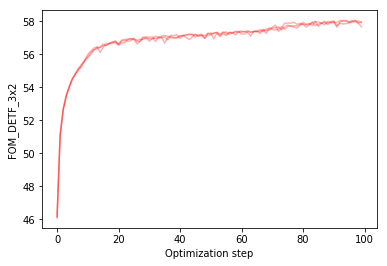

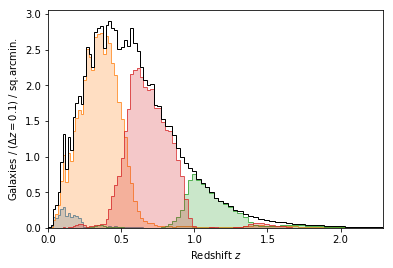

Starting job at 2020-09-11 17:04:37.280846 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 57.500 (max 57.500) validation 57.634.
Trial 1/3 epoch 11/100 train 70.495 (max 70.495) validation 70.492.
Trial 1/3 epoch 21/100 train 71.524 (max 71.543) validation 71.580.
Trial 1/3 epoch 31/100 train 72.167 (max 72.167) validation 72.106.
Trial 1/3 epoch 41/100 train 73.214 (max 73.214) validation 73.143.
Trial 1/3 epoch 51/100 train 73.522 (max 73.522) validation 73.458.
Trial 1/3 epoch 61/100 train 73.288 (max 73.543) validation 73.245.
Trial 1/3 epoch 71/100 train 73.747 (max 73.747) validation 73.623.
Trial 1/3 epoch 81/100 train 73.756 (max 73.799) validation 73.698.
Trial 1/3 epoch 91/100 train 73.859 (max 73.859) validation 73.791.
Trial 2/3 epoch 1/100 train 57.631 (max 73.891) validation 57.762.
Trial 2/3 epoch 11/100 train 70.689 (max 73.891) 

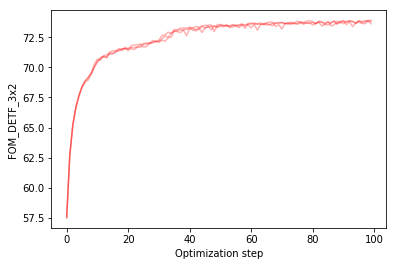

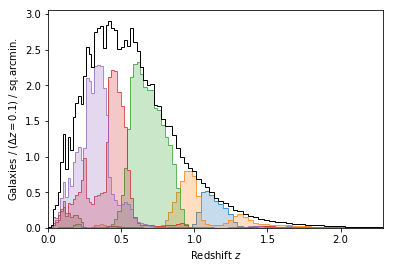

Starting job at 2020-09-11 17:08:28.532964 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 59.082 (max 59.082) validation 59.442.
Trial 1/3 epoch 11/100 train 81.649 (max 81.649) validation 81.799.
Trial 1/3 epoch 21/100 train 82.735 (max 82.763) validation 82.814.
Trial 1/3 epoch 31/100 train 83.193 (max 83.193) validation 83.249.
Trial 1/3 epoch 41/100 train 83.056 (max 83.320) validation 83.266.
Trial 1/3 epoch 51/100 train 83.544 (max 83.605) validation 83.678.
Trial 1/3 epoch 61/100 train 83.820 (max 83.898) validation 83.981.
Trial 1/3 epoch 71/100 train 84.063 (max 84.090) validation 84.215.
Trial 1/3 epoch 81/100 train 84.097 (max 84.362) validation 84.287.
Trial 1/3 epoch 91/100 train 85.305 (max 85.305) validation 85.215.
Trial 2/3 epoch 1/100 train 59.541 (max 85.637) validation 59.891.
Trial 2/3 epoch 11/100 train 81.547 (max 85.637) 

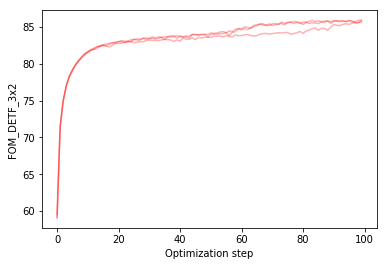

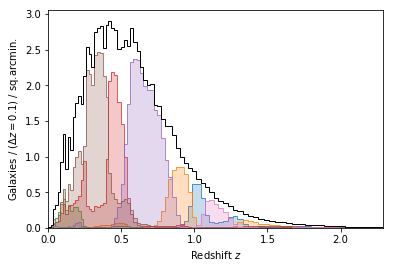

Starting job at 2020-09-11 17:13:15.111614 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 64.130 (max 64.130) validation 64.622.
Trial 1/3 epoch 11/100 train 90.203 (max 90.203) validation 90.285.
Trial 1/3 epoch 21/100 train 91.876 (max 92.064) validation 91.939.
Trial 1/3 epoch 31/100 train 92.919 (max 92.919) validation 92.873.
Trial 1/3 epoch 41/100 train 93.623 (max 93.623) validation 93.637.
Trial 1/3 epoch 51/100 train 93.968 (max 93.968) validation 93.962.
Trial 1/3 epoch 61/100 train 94.113 (max 94.182) validation 94.072.
Trial 1/3 epoch 71/100 train 94.229 (max 94.308) validation 94.221.
Trial 1/3 epoch 81/100 train 94.263 (max 94.390) validation 94.265.
Trial 1/3 epoch 91/100 train 94.402 (max 94.485) validation 94.359.
Trial 2/3 epoch 1/100 train 64.379 (max 94.538) validation 64.862.
Trial 2/3 epoch 11/100 train 90.224 (max 94.538)

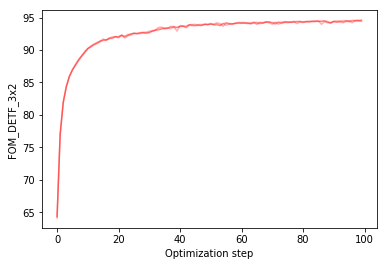

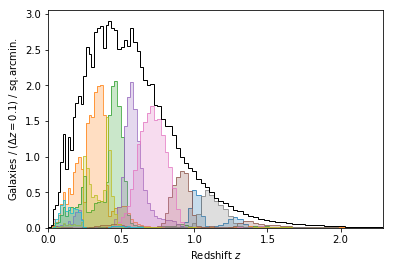

In [15]:
run_study('results/nn-2-64-detf', learn_nnet)

## Sandbox

Assign bin labels to a sample based on optimized weights:

In [67]:
def get_labels(z, w, seed=1):
    nds = len(zds) - 1
    gen = np.random.RandomState(seed)
    # Assign each redshift to an input redshift bin.
    idx = np.clip(np.digitize(z, zds) - 1, 0, nds - 1)
    # Calculate the CDF for mapping each input bin to output bins.
    cdf = np.cumsum(w, axis=0)
    cdf /= cdf[-1]
    # Loop over input bins to assign output bins sampled from the CDF.
    labels = np.empty(len(z), int)
    for i in range(nds):
        sel = idx == i
        nsel = np.count_nonzero(sel)
        u = gen.uniform(size=nsel)
        labels[sel] = np.searchsorted(cdf[:, i], u)
    return labels
    
labels4 = get_labels(zbuz, wbest4)

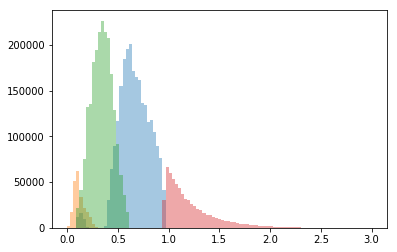

In [68]:
def plot_labels(z, labels):
    nbin = labels.max() + 1
    for i in range(nbin):
        sel = labels == i
        plt.hist(z[sel], bins=np.linspace(0, 3, 100), histtype='stepfilled', alpha=0.4)
        
plot_labels(zbuz, labels4)

In [69]:
np.save('buzzard_labels4.npy', labels4.astype(np.uint8))